**Welcome to Assignment 3 on Deep Learning for Computer Vision.**

This assignment consists of three parts. Part-1 is based on the content you learned in Week-5 of course and Part-2 is based on the content you learned in Week-6 of the course. 


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(2021)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2021)

### Data Loading and Pre-processing

In [10]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### YOUR CODE ENDS HERE ####

# Hyper parameters
num_epochs = 10
num_classes = 10
batch_size = 100
learning_rate = 0.001

#### YOUR CODE STARTS HERE ####
# define a transforms for preparing the dataset
# for normalization of the MNIST dataset, take mean=0.1307 and std=0.3081
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,),(0.3081,))])
#### YOUR CODE ENDS HERE ####

In [11]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=True,transform=transform)
test_dataset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=False,transform=transform)
#### YOUR CODE ENDS HERE ####

In [12]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [24]:
# Convolutional neural network (Two convolutional layers)
class ConvolutionNet(nn.Module):
    def __init__(self, num_classes=10):
        super( ConvolutionNet, self).__init__()
        
        # define a sequential module with 
        # 1. conv layer with input channel as 1, output channels as 16, kernel size of 7, stride of 1 and padding 3
        # 2. 2D BatchNorm of 16 features 
        # 3. ReLU activation
        # 4. 2D MaxPool with kernel size of 2 and stride of 2
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),  #num_features – C from an expected input of size (N, C, H, W)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #### YOUR CODE STARTS HERE ####
        # define a sequential module with 
        # 1. conv layer with input channel as 16, output channels as 32, kernel size of 5, stride of 1 and padding 2
        # 2. 2D BatchNorm of 32 features 
        # 3. ReLU activation
        # 4. 2D MaxPool with kernel size of 2 and stride of 2
        self.conv_block2 = nn.Sequential(
                           nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2),
                           nn.BatchNorm2d(32),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2,stride=2))
    
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc =  nn.Linear(32*7*7,10) # we don't go for batch size here
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the sequential convolution blocks defined above (conv_block1--> conv_block2-->fc) and 
        # write the forward pass.
        
        output = self.conv_block1(x)
        output = self.conv_block2(output)
        #print(output.shape)
        #### YOUR CODE STARTS HERE ####
        output = output.view(-1,32*7*7)
        output = self.fc(output)

        #### YOUR CODE ENDS HERE ####
        return output


### Question 1

What is the size of parameter matrix corresponding to convolution layer of second sequential block ? 

1. 32x16x5x5
2. 32x32x6x6
3. 32x64x7x7
4. 32x16x4x4

In [25]:
#### YOUR CODE STARTS HERE ####
model = ConvolutionNet()
model.conv_block2[0].weight.shape
#or
# params=list(model.parameters())
# params[4].shape
#### YOUR CODE ENDS HERE ####

torch.Size([32, 16, 5, 5])

### Training and Inference

In [26]:
#define the model
#### YOUR CODE STARTS HERE ####
model = ConvolutionNet()
model.to(device)
#### YOUR CODE ENDS HERE ####


#define cross entropy loss and Adam optimizer using learning rate=learning_rate
#### YOUR CODE STARTS HERE ####
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
#### YOUR CODE ENDS HERE ####

# Train the model
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
       #### YOUR CODE STARTS HERE ####
        # Hint: You can refer previous assignment !!!
        # send the image, target to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(images)
        # calculate the loss (use cross entropy in pytorch)
        loss = criterion(output,labels)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
       #### YOUR CODE ENDS HERE ####
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
      ### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        images = images.to(device)
        labels = labels.to(device)
        # pass the image to the model and assign the output to variable named output
        outputs = model(images)
      #### YOUR CODE ENDS HERE ####
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model : {} %'.format(100 * correct / total))

Epoch [1/10], Step [100/1875], Loss: 0.4186
Epoch [1/10], Step [200/1875], Loss: 0.1357
Epoch [1/10], Step [300/1875], Loss: 0.1341
Epoch [1/10], Step [400/1875], Loss: 0.0165
Epoch [1/10], Step [500/1875], Loss: 0.0165
Epoch [1/10], Step [600/1875], Loss: 0.0192
Epoch [1/10], Step [700/1875], Loss: 0.0665
Epoch [1/10], Step [800/1875], Loss: 0.0469
Epoch [1/10], Step [900/1875], Loss: 0.0028
Epoch [1/10], Step [1000/1875], Loss: 0.2776
Epoch [1/10], Step [1100/1875], Loss: 0.1720
Epoch [1/10], Step [1200/1875], Loss: 0.0278
Epoch [1/10], Step [1300/1875], Loss: 0.0549
Epoch [1/10], Step [1400/1875], Loss: 0.2315
Epoch [1/10], Step [1500/1875], Loss: 0.0048
Epoch [1/10], Step [1600/1875], Loss: 0.0078
Epoch [1/10], Step [1700/1875], Loss: 0.0206
Epoch [1/10], Step [1800/1875], Loss: 0.1380
Epoch [2/10], Step [100/1875], Loss: 0.0224
Epoch [2/10], Step [200/1875], Loss: 0.0119
Epoch [2/10], Step [300/1875], Loss: 0.0269
Epoch [2/10], Step [400/1875], Loss: 0.0231
Epoch [2/10], Step [500

#### Question-2

Report the final test accuracy displayed above (If you are not getting the exact number shown in options, please report the closest number).
1. 84%
2. 76%
3. 99%
4. 57%

### Densenet from scratch

In this question, you'll have to code Densenet from scratch (we have provided a lot starter code), this'll help you get a hold on how to code an architecture with bottleneck layers.

It's suggested you first briefly understand how the Densenet architecture is defined originally before you start with this question. We do take inspiration from the original Pytorch implementation, but if you try peeking into the original source code in the library, it'll confuse you more than helping!

**Sidenote:** As this assignment is mainly focused on learning things, we train the models only for a small number of epochs and don't focus on hyper-parameter tuning. When you start using deep learning in real-world applications and competitions, hyper-parameter tuning plays a decent role!

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import timeit
import unittest
import math
from torch.autograd import Variable

## Please DONOT remove these lines. 
torch.manual_seed(2021)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2021)

In [2]:
# check availability of GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a set of transforms for preparing the dataset
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=8), 
        transforms.RandomHorizontalFlip(), # flip the image horizontally (use pytorch random horizontal flip)
        transforms.ToTensor(), # convert the image to a pytorch tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # normalise the images with mean and std of the dataset
        ])

# define transforms for the test data: Should they be same as the one used for train? 
transform_test = transforms.Compose([                    
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

use_cuda = torch.cuda.is_available() # if you have acess to a GPU, enable it to speed the training 

In [3]:
# Load the CIFAR10 training, test datasets using `torchvision.datasets.cifar10`
#### YOUR CODE STARTS HERE ####
traindata = torchvision.datasets.CIFAR10('data',train = True,download = True, transform = transform_train)
testdata = torchvision.datasets.CIFAR10('data',train = False, download = True, transform = transform_test)
#### YOUR CODE ENDS HERE ####

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(traindata,batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testdata,batch_size=32,shuffle=True)
#### YOUR CODE ENDS HERE ####

In [5]:
class SingleLayer(nn.Module):
    def __init__(self, nChannels, outChannels):
        super(SingleLayer, self).__init__()
    #### YOUR CODE STARTS HERE ####
        # define a batchnorm2d layer with number of channels equal to nChannels
        self.bn1 = nn.BatchNorm2d(nChannels)
        # define a convolutional layer with input channels=nChannels, number of output channels=outChannels
        # kernel size of 3x3
        # use padding of 1
        # set bias to False
        self.conv1 = nn.Conv2d(nChannels,outChannels,kernel_size = 3,padding=1,bias=False)
    #### YOUR CODE ENDS HERE ####

    def forward(self, x):
  
        # pass the input through, bn1->relu->conv1
        out =  self.conv1(F.relu(self.bn1(x)))
   #### YOUR CODE STARTS HERE ####
        # contactinate output with the input , try using cat function
        out = torch.cat((x, out),dim=1)
        #print(out.shape)
    #### YOUR CODE ENDS HERE ####
        return out

class Transition(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(Transition, self).__init__()
    #### YOUR CODE STARTS HERE ####
        # define a batchnorm2d layer with number of channels equal to inChannels
        self.bn1 = nn.BatchNorm2d(inChannels)
        # define a convolutional layer with input channels=inChannels, number of output channels=outChannels
        # kernel size of 1x1
        # set bias to False
        self.conv1 = nn.Conv2d(inChannels, outChannels,kernel_size=1,bias=False)
    #### YOUR CODE ENDS HERE ####

    def forward(self, x):
    
        # pass the input through, bn1->relu->conv1
        out = self.conv1(F.relu(self.bn1(x)))
   #### YOUR CODE STARTS HERE ####
        # pass output through avg_pool2d with stride=2
        out = F.avg_pool2d(out, kernel_size=2,stride=2)
    #### YOUR CODE ENDS HERE ####
        return out


In [6]:
class DenseNet(nn.Module):
    def __init__(self, growthRate, reduction, nClasses):
        super(DenseNet, self).__init__()
        # number of dense blocks
        nBlocks = 4  #actually the number of layers in one dense block

        inChannels = 2*growthRate
        #### YOUR CODE STARTS HERE ####
        # define a convolutional layer with input channels=3, number of output channels=inChannels
        # kernel size of 3x3
        # use padding of 1
        # set bias to False
        self.conv1 = nn.Conv2d(3,inChannels,kernel_size=3,padding=1,bias=False)
        # use _make_dense (defined below) function to make a dense block of 4 blocks
        # pass inChannels, growthRate and nBlocks as parameter
        self.dense1 = self._make_dense(inChannels, growthRate, nBlocks)
        inChannels += nBlocks*growthRate
        OutChannels = int(math.floor(inChannels*reduction))
        # define a Transition block with input channels=inChannels, number of output channels=OutChannels
        self.trans1 = Transition(inChannels, OutChannels)

        inChannels = OutChannels
        # use _make_dense function to make a dense block of 4 blocks
        # pass inChannels, growthRate and nBlocks as parameter
        self.dense2 = self._make_dense(inChannels, growthRate, nBlocks)
        inChannels += nBlocks*growthRate
        OutChannels = int(math.floor(inChannels*reduction))
        # define a Transition block with input channels=inChannels, number of output channels=OutChannels
        self.trans2 = Transition(inChannels, OutChannels)

        inChannels = OutChannels
        # define a batchnorm2d layer with number of channels equal to inChannels
        self.bn1 = nn.BatchNorm2d(inChannels)
        # define a linear layer with input neurons=inChannels and output neurons=nClasses
        self.fc = nn.Linear(inChannels,nClasses)
        #### YOUR CODE ENDS HERE ####

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, inChannels, growthRate, nBlocks):
        layers = []
        for i in range(int(nBlocks)):
            layers.append(SingleLayer(inChannels, growthRate))
            inChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        # pass the input through conv1->dense1->trans1
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
     #### YOUR CODE STARTS HERE ####
        # pass the output through dense2->trans2
        out = self.trans2(self.dense2(out))
        # pass the output through bn1->relu->avg_pool2d
        #flatten the output (you can use squeeze function)
    
        out = F.avg_pool2d(F.relu(self.bn1(out)),kernel_size=F.relu(self.bn1(out)).shape[2])
        
        out = out.view(out.shape[0],-1)
        #pass the output through fc->log_softmax
        #print(out.shape)
        out = F.log_softmax(self.fc(out))
    #### YOUR CODE ENDS HERE ####
        return out

In [10]:
def train(epoch, net, trainLoader, optimizer):


    net.train()
    nProcessed = 0
    nTrain = len(trainLoader.dataset)
    step=0
    for batch_idx, (data, target) in enumerate(trainLoader):
        step+=1
        #print(step)
        # send the data, target to the device 
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the data to the model and assign the output to variable named output
        output = net(data)
        # calculate the loss (use nll_loss)
        #print(output.shape,target.shape)
        loss = F.nll_loss(output, target)
        # do a backward pass on loss
        loss.backward()
        # update the weights
        optimizer.step()

        nProcessed += len(data)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect = pred.ne(target.data).cpu().sum()
        err = 100.*incorrect/len(data)
        partialEpoch = epoch + batch_idx / len(trainLoader) - 1
        print('Train Epoch: {:.2f} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tError: {:.6f}'.format(
            partialEpoch, nProcessed, nTrain, 100. * batch_idx / len(trainLoader),
            loss.item(), err))

In [8]:
def test(epoch, net, testLoader, optimizer):
    net.eval()
    test_loss = 0
    incorrect = 0
    for data, target in testLoader:
        # send the data, target to the device
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        # pass the image to the model and assign the output to variable named output
        output =net(data)

        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect += pred.ne(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testLoader) # loss function already averages over batch size
    nTotal = len(testLoader.dataset)
    err = 100.*incorrect/nTotal
    print('\nTest set: Average loss: {:.4f}, Error: {}/{} ({:.0f}%)\n'.format(
        test_loss, incorrect, nTotal, err))


#### Question-3

Report the final test accuracy displayed below (If you are not getting the exact number shown in options, please report the closest number).
1. 94%
2. 61%
3. 38%
4. 85%

In [9]:
### YOUR CODE STARTS HERE ####
#define the Densenet model with growthRate=2, reduction=0.5 and number of classes=10
model = DenseNet(growthRate=2, reduction=0.5,nClasses=10)
print('  + Number of params: {}'.format(sum([p.data.nelement() for p in model.parameters()])))
#move the model to cuda
model = model.cuda()
## Define SGD Optimiser with a learning rate of 0.01
optimizer = optim.SGD(model.parameters(),lr=0.01)
### YOUR CODE ENDS HERE ####
for epoch in range(1, 5):
        train(1, model, train_dataloader, optimizer)
        test(1,model, test_dataloader, optimizer)

  + Number of params: 1704
1


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0.00 [32/50000 (0%)]	Loss: 2.313804	Error: 93.750000
2
Train Epoch: 0.00 [64/50000 (0%)]	Loss: 2.354564	Error: 84.375000
3
Train Epoch: 0.00 [96/50000 (0%)]	Loss: 2.429292	Error: 100.000000
4
Train Epoch: 0.00 [128/50000 (0%)]	Loss: 2.223654	Error: 81.250000
5
Train Epoch: 0.00 [160/50000 (0%)]	Loss: 2.369023	Error: 96.875000
6
Train Epoch: 0.00 [192/50000 (0%)]	Loss: 2.333490	Error: 90.625000
7
Train Epoch: 0.00 [224/50000 (0%)]	Loss: 2.358040	Error: 93.750000
8
Train Epoch: 0.00 [256/50000 (0%)]	Loss: 2.368638	Error: 96.875000
9
Train Epoch: 0.01 [288/50000 (1%)]	Loss: 2.342117	Error: 90.625000
10
Train Epoch: 0.01 [320/50000 (1%)]	Loss: 2.393121	Error: 96.875000
11
Train Epoch: 0.01 [352/50000 (1%)]	Loss: 2.329429	Error: 93.750000
12
Train Epoch: 0.01 [384/50000 (1%)]	Loss: 2.326275	Error: 90.625000
13
Train Epoch: 0.01 [416/50000 (1%)]	Loss: 2.306317	Error: 90.625000
14
Train Epoch: 0.01 [448/50000 (1%)]	Loss: 2.347559	Error: 93.750000
15
Train Epoch: 0.01 [480/50000 (

117
Train Epoch: 0.07 [3744/50000 (7%)]	Loss: 2.342216	Error: 100.000000
118
Train Epoch: 0.07 [3776/50000 (7%)]	Loss: 2.283137	Error: 81.250000
119
Train Epoch: 0.08 [3808/50000 (8%)]	Loss: 2.238012	Error: 87.500000
120
Train Epoch: 0.08 [3840/50000 (8%)]	Loss: 2.302629	Error: 93.750000
121
Train Epoch: 0.08 [3872/50000 (8%)]	Loss: 2.313893	Error: 93.750000
122
Train Epoch: 0.08 [3904/50000 (8%)]	Loss: 2.293232	Error: 87.500000
123
Train Epoch: 0.08 [3936/50000 (8%)]	Loss: 2.276115	Error: 90.625000
124
Train Epoch: 0.08 [3968/50000 (8%)]	Loss: 2.330377	Error: 90.625000
125
Train Epoch: 0.08 [4000/50000 (8%)]	Loss: 2.324820	Error: 90.625000
126
Train Epoch: 0.08 [4032/50000 (8%)]	Loss: 2.352609	Error: 93.750000
127
Train Epoch: 0.08 [4064/50000 (8%)]	Loss: 2.223344	Error: 78.125000
128
Train Epoch: 0.08 [4096/50000 (8%)]	Loss: 2.284544	Error: 84.375000
129
Train Epoch: 0.08 [4128/50000 (8%)]	Loss: 2.266559	Error: 90.625000
130
Train Epoch: 0.08 [4160/50000 (8%)]	Loss: 2.353418	Error: 9

Train Epoch: 0.15 [7424/50000 (15%)]	Loss: 2.266048	Error: 93.750000
233
Train Epoch: 0.15 [7456/50000 (15%)]	Loss: 2.314308	Error: 93.750000
234
Train Epoch: 0.15 [7488/50000 (15%)]	Loss: 2.327121	Error: 96.875000
235
Train Epoch: 0.15 [7520/50000 (15%)]	Loss: 2.299064	Error: 90.625000
236
Train Epoch: 0.15 [7552/50000 (15%)]	Loss: 2.309895	Error: 87.500000
237
Train Epoch: 0.15 [7584/50000 (15%)]	Loss: 2.289087	Error: 90.625000
238
Train Epoch: 0.15 [7616/50000 (15%)]	Loss: 2.334892	Error: 96.875000
239
Train Epoch: 0.15 [7648/50000 (15%)]	Loss: 2.254623	Error: 90.625000
240
Train Epoch: 0.15 [7680/50000 (15%)]	Loss: 2.301077	Error: 87.500000
241
Train Epoch: 0.15 [7712/50000 (15%)]	Loss: 2.294423	Error: 90.625000
242
Train Epoch: 0.15 [7744/50000 (15%)]	Loss: 2.279753	Error: 93.750000
243
Train Epoch: 0.15 [7776/50000 (15%)]	Loss: 2.245294	Error: 84.375000
244
Train Epoch: 0.16 [7808/50000 (16%)]	Loss: 2.343019	Error: 96.875000
245
Train Epoch: 0.16 [7840/50000 (16%)]	Loss: 2.320241

Train Epoch: 0.22 [11008/50000 (22%)]	Loss: 2.325898	Error: 96.875000
345
Train Epoch: 0.22 [11040/50000 (22%)]	Loss: 2.281643	Error: 90.625000
346
Train Epoch: 0.22 [11072/50000 (22%)]	Loss: 2.272050	Error: 87.500000
347
Train Epoch: 0.22 [11104/50000 (22%)]	Loss: 2.328219	Error: 100.000000
348
Train Epoch: 0.22 [11136/50000 (22%)]	Loss: 2.249245	Error: 90.625000
349
Train Epoch: 0.22 [11168/50000 (22%)]	Loss: 2.249480	Error: 78.125000
350
Train Epoch: 0.22 [11200/50000 (22%)]	Loss: 2.192464	Error: 87.500000
351
Train Epoch: 0.22 [11232/50000 (22%)]	Loss: 2.290508	Error: 90.625000
352
Train Epoch: 0.22 [11264/50000 (22%)]	Loss: 2.299049	Error: 93.750000
353
Train Epoch: 0.23 [11296/50000 (23%)]	Loss: 2.273316	Error: 84.375000
354
Train Epoch: 0.23 [11328/50000 (23%)]	Loss: 2.254421	Error: 90.625000
355
Train Epoch: 0.23 [11360/50000 (23%)]	Loss: 2.224421	Error: 78.125000
356
Train Epoch: 0.23 [11392/50000 (23%)]	Loss: 2.349590	Error: 87.500000
357
Train Epoch: 0.23 [11424/50000 (23%)]

Train Epoch: 0.29 [14624/50000 (29%)]	Loss: 2.218503	Error: 75.000000
458
Train Epoch: 0.29 [14656/50000 (29%)]	Loss: 2.203727	Error: 78.125000
459
Train Epoch: 0.29 [14688/50000 (29%)]	Loss: 2.294767	Error: 93.750000
460
Train Epoch: 0.29 [14720/50000 (29%)]	Loss: 2.259063	Error: 87.500000
461
Train Epoch: 0.29 [14752/50000 (29%)]	Loss: 2.211927	Error: 81.250000
462
Train Epoch: 0.29 [14784/50000 (29%)]	Loss: 2.294483	Error: 87.500000
463
Train Epoch: 0.30 [14816/50000 (30%)]	Loss: 2.252344	Error: 93.750000
464
Train Epoch: 0.30 [14848/50000 (30%)]	Loss: 2.255233	Error: 84.375000
465
Train Epoch: 0.30 [14880/50000 (30%)]	Loss: 2.296844	Error: 81.250000
466
Train Epoch: 0.30 [14912/50000 (30%)]	Loss: 2.319896	Error: 81.250000
467
Train Epoch: 0.30 [14944/50000 (30%)]	Loss: 2.292456	Error: 84.375000
468
Train Epoch: 0.30 [14976/50000 (30%)]	Loss: 2.286615	Error: 90.625000
469
Train Epoch: 0.30 [15008/50000 (30%)]	Loss: 2.235973	Error: 75.000000
470
Train Epoch: 0.30 [15040/50000 (30%)]	

Train Epoch: 0.36 [18240/50000 (36%)]	Loss: 2.241251	Error: 68.750000
571
Train Epoch: 0.36 [18272/50000 (36%)]	Loss: 2.225347	Error: 78.125000
572
Train Epoch: 0.37 [18304/50000 (37%)]	Loss: 2.259304	Error: 81.250000
573
Train Epoch: 0.37 [18336/50000 (37%)]	Loss: 2.248718	Error: 84.375000
574
Train Epoch: 0.37 [18368/50000 (37%)]	Loss: 2.177835	Error: 75.000000
575
Train Epoch: 0.37 [18400/50000 (37%)]	Loss: 2.203694	Error: 78.125000
576
Train Epoch: 0.37 [18432/50000 (37%)]	Loss: 2.203800	Error: 68.750000
577
Train Epoch: 0.37 [18464/50000 (37%)]	Loss: 2.296723	Error: 84.375000
578
Train Epoch: 0.37 [18496/50000 (37%)]	Loss: 2.296271	Error: 90.625000
579
Train Epoch: 0.37 [18528/50000 (37%)]	Loss: 2.270119	Error: 78.125000
580
Train Epoch: 0.37 [18560/50000 (37%)]	Loss: 2.212645	Error: 75.000000
581
Train Epoch: 0.37 [18592/50000 (37%)]	Loss: 2.231267	Error: 68.750000
582
Train Epoch: 0.37 [18624/50000 (37%)]	Loss: 2.191154	Error: 62.500000
583
Train Epoch: 0.37 [18656/50000 (37%)]	

Train Epoch: 0.44 [21856/50000 (44%)]	Loss: 2.211133	Error: 84.375000
684
Train Epoch: 0.44 [21888/50000 (44%)]	Loss: 2.273583	Error: 84.375000
685
Train Epoch: 0.44 [21920/50000 (44%)]	Loss: 2.256219	Error: 81.250000
686
Train Epoch: 0.44 [21952/50000 (44%)]	Loss: 2.266867	Error: 93.750000
687
Train Epoch: 0.44 [21984/50000 (44%)]	Loss: 2.282958	Error: 84.375000
688
Train Epoch: 0.44 [22016/50000 (44%)]	Loss: 2.262904	Error: 81.250000
689
Train Epoch: 0.44 [22048/50000 (44%)]	Loss: 2.244435	Error: 84.375000
690
Train Epoch: 0.44 [22080/50000 (44%)]	Loss: 2.205261	Error: 93.750000
691
Train Epoch: 0.44 [22112/50000 (44%)]	Loss: 2.268708	Error: 87.500000
692
Train Epoch: 0.44 [22144/50000 (44%)]	Loss: 2.277067	Error: 84.375000
693
Train Epoch: 0.44 [22176/50000 (44%)]	Loss: 2.291786	Error: 84.375000
694
Train Epoch: 0.44 [22208/50000 (44%)]	Loss: 2.329591	Error: 90.625000
695
Train Epoch: 0.44 [22240/50000 (44%)]	Loss: 2.262354	Error: 90.625000
696
Train Epoch: 0.44 [22272/50000 (44%)]	

797
Train Epoch: 0.51 [25504/50000 (51%)]	Loss: 2.200531	Error: 78.125000
798
Train Epoch: 0.51 [25536/50000 (51%)]	Loss: 2.200047	Error: 75.000000
799
Train Epoch: 0.51 [25568/50000 (51%)]	Loss: 2.266884	Error: 87.500000
800
Train Epoch: 0.51 [25600/50000 (51%)]	Loss: 2.223363	Error: 78.125000
801
Train Epoch: 0.51 [25632/50000 (51%)]	Loss: 2.246448	Error: 81.250000
802
Train Epoch: 0.51 [25664/50000 (51%)]	Loss: 2.198376	Error: 78.125000
803
Train Epoch: 0.51 [25696/50000 (51%)]	Loss: 2.233864	Error: 84.375000
804
Train Epoch: 0.51 [25728/50000 (51%)]	Loss: 2.242998	Error: 84.375000
805
Train Epoch: 0.51 [25760/50000 (51%)]	Loss: 2.217991	Error: 75.000000
806
Train Epoch: 0.52 [25792/50000 (52%)]	Loss: 2.185085	Error: 81.250000
807
Train Epoch: 0.52 [25824/50000 (52%)]	Loss: 2.170854	Error: 75.000000
808
Train Epoch: 0.52 [25856/50000 (52%)]	Loss: 2.128222	Error: 75.000000
809
Train Epoch: 0.52 [25888/50000 (52%)]	Loss: 2.156073	Error: 71.875000
810
Train Epoch: 0.52 [25920/50000 (52

Train Epoch: 0.58 [29216/50000 (58%)]	Loss: 2.207609	Error: 75.000000
914
Train Epoch: 0.58 [29248/50000 (58%)]	Loss: 2.182651	Error: 68.750000
915
Train Epoch: 0.58 [29280/50000 (58%)]	Loss: 2.128378	Error: 81.250000
916
Train Epoch: 0.59 [29312/50000 (59%)]	Loss: 2.276126	Error: 93.750000
917
Train Epoch: 0.59 [29344/50000 (59%)]	Loss: 2.190228	Error: 75.000000
918
Train Epoch: 0.59 [29376/50000 (59%)]	Loss: 2.180879	Error: 75.000000
919
Train Epoch: 0.59 [29408/50000 (59%)]	Loss: 2.182460	Error: 87.500000
920
Train Epoch: 0.59 [29440/50000 (59%)]	Loss: 2.197409	Error: 78.125000
921
Train Epoch: 0.59 [29472/50000 (59%)]	Loss: 2.194373	Error: 87.500000
922
Train Epoch: 0.59 [29504/50000 (59%)]	Loss: 2.185524	Error: 78.125000
923
Train Epoch: 0.59 [29536/50000 (59%)]	Loss: 2.179261	Error: 84.375000
924
Train Epoch: 0.59 [29568/50000 (59%)]	Loss: 2.186166	Error: 84.375000
925
Train Epoch: 0.59 [29600/50000 (59%)]	Loss: 2.182834	Error: 84.375000
926
Train Epoch: 0.59 [29632/50000 (59%)]	

1027
Train Epoch: 0.66 [32864/50000 (66%)]	Loss: 2.124208	Error: 71.875000
1028
Train Epoch: 0.66 [32896/50000 (66%)]	Loss: 2.177259	Error: 87.500000
1029
Train Epoch: 0.66 [32928/50000 (66%)]	Loss: 2.205719	Error: 71.875000
1030
Train Epoch: 0.66 [32960/50000 (66%)]	Loss: 2.153651	Error: 71.875000
1031
Train Epoch: 0.66 [32992/50000 (66%)]	Loss: 2.144653	Error: 71.875000
1032
Train Epoch: 0.66 [33024/50000 (66%)]	Loss: 2.132174	Error: 75.000000
1033
Train Epoch: 0.66 [33056/50000 (66%)]	Loss: 2.199476	Error: 75.000000
1034
Train Epoch: 0.66 [33088/50000 (66%)]	Loss: 2.140220	Error: 84.375000
1035
Train Epoch: 0.66 [33120/50000 (66%)]	Loss: 2.205315	Error: 84.375000
1036
Train Epoch: 0.66 [33152/50000 (66%)]	Loss: 2.131721	Error: 68.750000
1037
Train Epoch: 0.66 [33184/50000 (66%)]	Loss: 2.175919	Error: 87.500000
1038
Train Epoch: 0.66 [33216/50000 (66%)]	Loss: 2.227479	Error: 90.625000
1039
Train Epoch: 0.66 [33248/50000 (66%)]	Loss: 2.100321	Error: 71.875000
1040
Train Epoch: 0.66 [3

1251
Train Epoch: 0.80 [40032/50000 (80%)]	Loss: 2.072018	Error: 71.875000
1252
Train Epoch: 0.80 [40064/50000 (80%)]	Loss: 2.152425	Error: 81.250000
1253
Train Epoch: 0.80 [40096/50000 (80%)]	Loss: 2.256157	Error: 90.625000
1254
Train Epoch: 0.80 [40128/50000 (80%)]	Loss: 2.097718	Error: 81.250000
1255
Train Epoch: 0.80 [40160/50000 (80%)]	Loss: 2.161407	Error: 78.125000
1256
Train Epoch: 0.80 [40192/50000 (80%)]	Loss: 2.138256	Error: 75.000000
1257
Train Epoch: 0.80 [40224/50000 (80%)]	Loss: 2.161118	Error: 78.125000
1258
Train Epoch: 0.80 [40256/50000 (80%)]	Loss: 2.141159	Error: 78.125000
1259
Train Epoch: 0.80 [40288/50000 (80%)]	Loss: 2.149655	Error: 84.375000
1260
Train Epoch: 0.81 [40320/50000 (81%)]	Loss: 2.183887	Error: 84.375000
1261
Train Epoch: 0.81 [40352/50000 (81%)]	Loss: 2.130676	Error: 81.250000
1262
Train Epoch: 0.81 [40384/50000 (81%)]	Loss: 2.177253	Error: 75.000000
1263
Train Epoch: 0.81 [40416/50000 (81%)]	Loss: 2.147070	Error: 90.625000
1264
Train Epoch: 0.81 [4

1369
Train Epoch: 0.88 [43808/50000 (88%)]	Loss: 2.231924	Error: 90.625000
1370
Train Epoch: 0.88 [43840/50000 (88%)]	Loss: 2.035101	Error: 75.000000
1371
Train Epoch: 0.88 [43872/50000 (88%)]	Loss: 2.162708	Error: 81.250000
1372
Train Epoch: 0.88 [43904/50000 (88%)]	Loss: 2.155566	Error: 84.375000
1373
Train Epoch: 0.88 [43936/50000 (88%)]	Loss: 2.110863	Error: 81.250000
1374
Train Epoch: 0.88 [43968/50000 (88%)]	Loss: 2.240801	Error: 75.000000
1375
Train Epoch: 0.88 [44000/50000 (88%)]	Loss: 2.176278	Error: 87.500000
1376
Train Epoch: 0.88 [44032/50000 (88%)]	Loss: 2.092071	Error: 78.125000
1377
Train Epoch: 0.88 [44064/50000 (88%)]	Loss: 2.272627	Error: 84.375000
1378
Train Epoch: 0.88 [44096/50000 (88%)]	Loss: 2.118156	Error: 78.125000
1379
Train Epoch: 0.88 [44128/50000 (88%)]	Loss: 2.059314	Error: 71.875000
1380
Train Epoch: 0.88 [44160/50000 (88%)]	Loss: 2.151808	Error: 81.250000
1381
Train Epoch: 0.88 [44192/50000 (88%)]	Loss: 2.216863	Error: 78.125000
1382
Train Epoch: 0.88 [4

1482
Train Epoch: 0.95 [47424/50000 (95%)]	Loss: 2.136405	Error: 75.000000
1483
Train Epoch: 0.95 [47456/50000 (95%)]	Loss: 2.020961	Error: 75.000000
1484
Train Epoch: 0.95 [47488/50000 (95%)]	Loss: 2.128909	Error: 75.000000
1485
Train Epoch: 0.95 [47520/50000 (95%)]	Loss: 2.171976	Error: 84.375000
1486
Train Epoch: 0.95 [47552/50000 (95%)]	Loss: 2.208824	Error: 90.625000
1487
Train Epoch: 0.95 [47584/50000 (95%)]	Loss: 2.242678	Error: 90.625000
1488
Train Epoch: 0.95 [47616/50000 (95%)]	Loss: 2.153122	Error: 84.375000
1489
Train Epoch: 0.95 [47648/50000 (95%)]	Loss: 2.178893	Error: 75.000000
1490
Train Epoch: 0.95 [47680/50000 (95%)]	Loss: 2.107177	Error: 81.250000
1491
Train Epoch: 0.95 [47712/50000 (95%)]	Loss: 2.118377	Error: 81.250000
1492
Train Epoch: 0.95 [47744/50000 (95%)]	Loss: 2.165589	Error: 84.375000
1493
Train Epoch: 0.95 [47776/50000 (95%)]	Loss: 2.134691	Error: 75.000000
1494
Train Epoch: 0.96 [47808/50000 (96%)]	Loss: 2.152543	Error: 75.000000
1495
Train Epoch: 0.96 [4

37
Train Epoch: 0.02 [1184/50000 (2%)]	Loss: 2.102085	Error: 81.250000
38
Train Epoch: 0.02 [1216/50000 (2%)]	Loss: 2.084547	Error: 78.125000
39
Train Epoch: 0.02 [1248/50000 (2%)]	Loss: 2.182533	Error: 87.500000
40
Train Epoch: 0.02 [1280/50000 (2%)]	Loss: 2.201374	Error: 81.250000
41
Train Epoch: 0.03 [1312/50000 (3%)]	Loss: 2.162324	Error: 90.625000
42
Train Epoch: 0.03 [1344/50000 (3%)]	Loss: 2.126592	Error: 81.250000
43
Train Epoch: 0.03 [1376/50000 (3%)]	Loss: 2.089747	Error: 75.000000
44
Train Epoch: 0.03 [1408/50000 (3%)]	Loss: 2.123533	Error: 78.125000
45
Train Epoch: 0.03 [1440/50000 (3%)]	Loss: 2.133243	Error: 68.750000
46
Train Epoch: 0.03 [1472/50000 (3%)]	Loss: 2.107208	Error: 78.125000
47
Train Epoch: 0.03 [1504/50000 (3%)]	Loss: 2.250155	Error: 78.125000
48
Train Epoch: 0.03 [1536/50000 (3%)]	Loss: 2.039474	Error: 78.125000
49
Train Epoch: 0.03 [1568/50000 (3%)]	Loss: 2.164130	Error: 75.000000
50
Train Epoch: 0.03 [1600/50000 (3%)]	Loss: 2.091058	Error: 78.125000
51
Tra

155
Train Epoch: 0.10 [4960/50000 (10%)]	Loss: 2.027850	Error: 75.000000
156
Train Epoch: 0.10 [4992/50000 (10%)]	Loss: 2.030860	Error: 65.625000
157
Train Epoch: 0.10 [5024/50000 (10%)]	Loss: 2.180385	Error: 71.875000
158
Train Epoch: 0.10 [5056/50000 (10%)]	Loss: 2.097927	Error: 81.250000
159
Train Epoch: 0.10 [5088/50000 (10%)]	Loss: 2.138329	Error: 78.125000
160
Train Epoch: 0.10 [5120/50000 (10%)]	Loss: 2.240431	Error: 90.625000
161
Train Epoch: 0.10 [5152/50000 (10%)]	Loss: 2.125364	Error: 78.125000
162
Train Epoch: 0.10 [5184/50000 (10%)]	Loss: 2.200979	Error: 87.500000
163
Train Epoch: 0.10 [5216/50000 (10%)]	Loss: 2.197464	Error: 75.000000
164
Train Epoch: 0.10 [5248/50000 (10%)]	Loss: 1.965375	Error: 59.375000
165
Train Epoch: 0.10 [5280/50000 (10%)]	Loss: 2.054990	Error: 75.000000
166
Train Epoch: 0.11 [5312/50000 (11%)]	Loss: 2.122901	Error: 87.500000
167
Train Epoch: 0.11 [5344/50000 (11%)]	Loss: 2.215960	Error: 87.500000
168
Train Epoch: 0.11 [5376/50000 (11%)]	Loss: 2.23

Train Epoch: 0.17 [8672/50000 (17%)]	Loss: 2.065589	Error: 78.125000
272
Train Epoch: 0.17 [8704/50000 (17%)]	Loss: 2.126345	Error: 84.375000
273
Train Epoch: 0.17 [8736/50000 (17%)]	Loss: 2.238875	Error: 90.625000
274
Train Epoch: 0.17 [8768/50000 (17%)]	Loss: 2.247518	Error: 96.875000
275
Train Epoch: 0.18 [8800/50000 (18%)]	Loss: 2.059140	Error: 62.500000
276
Train Epoch: 0.18 [8832/50000 (18%)]	Loss: 2.234789	Error: 87.500000
277
Train Epoch: 0.18 [8864/50000 (18%)]	Loss: 2.191545	Error: 93.750000
278
Train Epoch: 0.18 [8896/50000 (18%)]	Loss: 2.179033	Error: 90.625000
279
Train Epoch: 0.18 [8928/50000 (18%)]	Loss: 2.154655	Error: 84.375000
280
Train Epoch: 0.18 [8960/50000 (18%)]	Loss: 2.099423	Error: 65.625000
281
Train Epoch: 0.18 [8992/50000 (18%)]	Loss: 2.011658	Error: 68.750000
282
Train Epoch: 0.18 [9024/50000 (18%)]	Loss: 2.115826	Error: 90.625000
283
Train Epoch: 0.18 [9056/50000 (18%)]	Loss: 2.103635	Error: 68.750000
284
Train Epoch: 0.18 [9088/50000 (18%)]	Loss: 2.251791

389
Train Epoch: 0.25 [12448/50000 (25%)]	Loss: 2.004633	Error: 68.750000
390
Train Epoch: 0.25 [12480/50000 (25%)]	Loss: 2.051858	Error: 78.125000
391
Train Epoch: 0.25 [12512/50000 (25%)]	Loss: 2.146806	Error: 78.125000
392
Train Epoch: 0.25 [12544/50000 (25%)]	Loss: 2.241832	Error: 96.875000
393
Train Epoch: 0.25 [12576/50000 (25%)]	Loss: 2.058961	Error: 75.000000
394
Train Epoch: 0.25 [12608/50000 (25%)]	Loss: 2.069014	Error: 78.125000
395
Train Epoch: 0.25 [12640/50000 (25%)]	Loss: 2.073200	Error: 78.125000
396
Train Epoch: 0.25 [12672/50000 (25%)]	Loss: 2.143887	Error: 81.250000
397
Train Epoch: 0.25 [12704/50000 (25%)]	Loss: 2.060858	Error: 81.250000
398
Train Epoch: 0.25 [12736/50000 (25%)]	Loss: 2.135801	Error: 78.125000
399
Train Epoch: 0.25 [12768/50000 (25%)]	Loss: 2.046267	Error: 71.875000
400
Train Epoch: 0.26 [12800/50000 (26%)]	Loss: 2.027916	Error: 75.000000
401
Train Epoch: 0.26 [12832/50000 (26%)]	Loss: 2.093530	Error: 84.375000
402
Train Epoch: 0.26 [12864/50000 (26

501
Train Epoch: 0.32 [16032/50000 (32%)]	Loss: 2.172006	Error: 78.125000
502
Train Epoch: 0.32 [16064/50000 (32%)]	Loss: 2.067516	Error: 75.000000
503
Train Epoch: 0.32 [16096/50000 (32%)]	Loss: 2.023341	Error: 71.875000
504
Train Epoch: 0.32 [16128/50000 (32%)]	Loss: 2.049169	Error: 65.625000
505
Train Epoch: 0.32 [16160/50000 (32%)]	Loss: 2.201503	Error: 81.250000
506
Train Epoch: 0.32 [16192/50000 (32%)]	Loss: 2.104820	Error: 78.125000
507
Train Epoch: 0.32 [16224/50000 (32%)]	Loss: 2.019860	Error: 62.500000
508
Train Epoch: 0.32 [16256/50000 (32%)]	Loss: 2.109228	Error: 78.125000
509
Train Epoch: 0.33 [16288/50000 (33%)]	Loss: 2.096485	Error: 75.000000
510
Train Epoch: 0.33 [16320/50000 (33%)]	Loss: 2.064338	Error: 71.875000
511
Train Epoch: 0.33 [16352/50000 (33%)]	Loss: 2.081569	Error: 75.000000
512
Train Epoch: 0.33 [16384/50000 (33%)]	Loss: 2.078397	Error: 87.500000
513
Train Epoch: 0.33 [16416/50000 (33%)]	Loss: 2.124179	Error: 84.375000
514
Train Epoch: 0.33 [16448/50000 (33

619
Train Epoch: 0.40 [19808/50000 (40%)]	Loss: 2.124463	Error: 81.250000
620
Train Epoch: 0.40 [19840/50000 (40%)]	Loss: 2.102041	Error: 65.625000
621
Train Epoch: 0.40 [19872/50000 (40%)]	Loss: 2.159788	Error: 84.375000
622
Train Epoch: 0.40 [19904/50000 (40%)]	Loss: 2.070862	Error: 81.250000
623
Train Epoch: 0.40 [19936/50000 (40%)]	Loss: 2.133992	Error: 68.750000
624
Train Epoch: 0.40 [19968/50000 (40%)]	Loss: 2.087676	Error: 75.000000
625
Train Epoch: 0.40 [20000/50000 (40%)]	Loss: 2.106978	Error: 71.875000
626
Train Epoch: 0.40 [20032/50000 (40%)]	Loss: 1.969538	Error: 65.625000
627
Train Epoch: 0.40 [20064/50000 (40%)]	Loss: 2.037180	Error: 90.625000
628
Train Epoch: 0.40 [20096/50000 (40%)]	Loss: 2.086734	Error: 81.250000
629
Train Epoch: 0.40 [20128/50000 (40%)]	Loss: 2.275843	Error: 90.625000
630
Train Epoch: 0.40 [20160/50000 (40%)]	Loss: 2.071993	Error: 75.000000
631
Train Epoch: 0.40 [20192/50000 (40%)]	Loss: 2.041856	Error: 68.750000
632
Train Epoch: 0.40 [20224/50000 (40

736
Train Epoch: 0.47 [23552/50000 (47%)]	Loss: 2.227693	Error: 78.125000
737
Train Epoch: 0.47 [23584/50000 (47%)]	Loss: 2.226954	Error: 87.500000
738
Train Epoch: 0.47 [23616/50000 (47%)]	Loss: 2.093424	Error: 81.250000
739
Train Epoch: 0.47 [23648/50000 (47%)]	Loss: 1.983779	Error: 75.000000
740
Train Epoch: 0.47 [23680/50000 (47%)]	Loss: 2.122780	Error: 93.750000
741
Train Epoch: 0.47 [23712/50000 (47%)]	Loss: 2.033996	Error: 84.375000
742
Train Epoch: 0.47 [23744/50000 (47%)]	Loss: 2.122847	Error: 81.250000
743
Train Epoch: 0.47 [23776/50000 (47%)]	Loss: 2.037758	Error: 68.750000
744
Train Epoch: 0.48 [23808/50000 (48%)]	Loss: 2.194208	Error: 84.375000
745
Train Epoch: 0.48 [23840/50000 (48%)]	Loss: 2.002825	Error: 81.250000
746
Train Epoch: 0.48 [23872/50000 (48%)]	Loss: 1.987353	Error: 75.000000
747
Train Epoch: 0.48 [23904/50000 (48%)]	Loss: 2.132324	Error: 78.125000
748
Train Epoch: 0.48 [23936/50000 (48%)]	Loss: 2.116083	Error: 68.750000
749
Train Epoch: 0.48 [23968/50000 (48

854
Train Epoch: 0.55 [27328/50000 (55%)]	Loss: 2.072957	Error: 68.750000
855
Train Epoch: 0.55 [27360/50000 (55%)]	Loss: 2.003842	Error: 75.000000
856
Train Epoch: 0.55 [27392/50000 (55%)]	Loss: 2.170357	Error: 68.750000
857
Train Epoch: 0.55 [27424/50000 (55%)]	Loss: 2.073124	Error: 78.125000
858
Train Epoch: 0.55 [27456/50000 (55%)]	Loss: 2.068776	Error: 75.000000
859
Train Epoch: 0.55 [27488/50000 (55%)]	Loss: 2.134421	Error: 84.375000
860
Train Epoch: 0.55 [27520/50000 (55%)]	Loss: 1.982231	Error: 78.125000
861
Train Epoch: 0.55 [27552/50000 (55%)]	Loss: 2.225356	Error: 84.375000
862
Train Epoch: 0.55 [27584/50000 (55%)]	Loss: 2.118946	Error: 78.125000
863
Train Epoch: 0.55 [27616/50000 (55%)]	Loss: 2.094779	Error: 84.375000
864
Train Epoch: 0.55 [27648/50000 (55%)]	Loss: 2.165161	Error: 81.250000
865
Train Epoch: 0.55 [27680/50000 (55%)]	Loss: 2.080602	Error: 81.250000
866
Train Epoch: 0.55 [27712/50000 (55%)]	Loss: 2.092741	Error: 75.000000
867
Train Epoch: 0.55 [27744/50000 (55

973
Train Epoch: 0.62 [31136/50000 (62%)]	Loss: 2.059824	Error: 81.250000
974
Train Epoch: 0.62 [31168/50000 (62%)]	Loss: 2.072682	Error: 78.125000
975
Train Epoch: 0.62 [31200/50000 (62%)]	Loss: 2.101244	Error: 78.125000
976
Train Epoch: 0.62 [31232/50000 (62%)]	Loss: 2.275476	Error: 90.625000
977
Train Epoch: 0.62 [31264/50000 (62%)]	Loss: 2.047203	Error: 90.625000
978
Train Epoch: 0.63 [31296/50000 (63%)]	Loss: 2.202513	Error: 87.500000
979
Train Epoch: 0.63 [31328/50000 (63%)]	Loss: 2.194325	Error: 78.125000
980
Train Epoch: 0.63 [31360/50000 (63%)]	Loss: 2.143056	Error: 75.000000
981
Train Epoch: 0.63 [31392/50000 (63%)]	Loss: 1.940704	Error: 53.125000
982
Train Epoch: 0.63 [31424/50000 (63%)]	Loss: 2.181590	Error: 87.500000
983
Train Epoch: 0.63 [31456/50000 (63%)]	Loss: 2.228313	Error: 81.250000
984
Train Epoch: 0.63 [31488/50000 (63%)]	Loss: 2.128876	Error: 75.000000
985
Train Epoch: 0.63 [31520/50000 (63%)]	Loss: 2.201458	Error: 87.500000
986
Train Epoch: 0.63 [31552/50000 (63

Train Epoch: 0.70 [34880/50000 (70%)]	Loss: 2.049878	Error: 75.000000
1091
Train Epoch: 0.70 [34912/50000 (70%)]	Loss: 2.065114	Error: 84.375000
1092
Train Epoch: 0.70 [34944/50000 (70%)]	Loss: 2.175210	Error: 87.500000
1093
Train Epoch: 0.70 [34976/50000 (70%)]	Loss: 2.057971	Error: 81.250000
1094
Train Epoch: 0.70 [35008/50000 (70%)]	Loss: 2.167763	Error: 75.000000
1095
Train Epoch: 0.70 [35040/50000 (70%)]	Loss: 2.016573	Error: 62.500000
1096
Train Epoch: 0.70 [35072/50000 (70%)]	Loss: 2.084689	Error: 68.750000
1097
Train Epoch: 0.70 [35104/50000 (70%)]	Loss: 2.013702	Error: 81.250000
1098
Train Epoch: 0.70 [35136/50000 (70%)]	Loss: 2.163590	Error: 81.250000
1099
Train Epoch: 0.70 [35168/50000 (70%)]	Loss: 2.060652	Error: 78.125000
1100
Train Epoch: 0.70 [35200/50000 (70%)]	Loss: 2.194246	Error: 78.125000
1101
Train Epoch: 0.70 [35232/50000 (70%)]	Loss: 1.952263	Error: 71.875000
1102
Train Epoch: 0.70 [35264/50000 (70%)]	Loss: 2.179268	Error: 84.375000
1103
Train Epoch: 0.71 [35296/

1208
Train Epoch: 0.77 [38656/50000 (77%)]	Loss: 2.079323	Error: 71.875000
1209
Train Epoch: 0.77 [38688/50000 (77%)]	Loss: 1.983277	Error: 78.125000
1210
Train Epoch: 0.77 [38720/50000 (77%)]	Loss: 2.214701	Error: 78.125000
1211
Train Epoch: 0.77 [38752/50000 (77%)]	Loss: 1.866006	Error: 75.000000
1212
Train Epoch: 0.77 [38784/50000 (77%)]	Loss: 1.996184	Error: 78.125000
1213
Train Epoch: 0.78 [38816/50000 (78%)]	Loss: 1.941153	Error: 75.000000
1214
Train Epoch: 0.78 [38848/50000 (78%)]	Loss: 2.204786	Error: 84.375000
1215
Train Epoch: 0.78 [38880/50000 (78%)]	Loss: 2.150954	Error: 84.375000
1216
Train Epoch: 0.78 [38912/50000 (78%)]	Loss: 1.993638	Error: 75.000000
1217
Train Epoch: 0.78 [38944/50000 (78%)]	Loss: 2.069496	Error: 84.375000
1218
Train Epoch: 0.78 [38976/50000 (78%)]	Loss: 2.092745	Error: 81.250000
1219
Train Epoch: 0.78 [39008/50000 (78%)]	Loss: 2.012716	Error: 75.000000
1220
Train Epoch: 0.78 [39040/50000 (78%)]	Loss: 2.055341	Error: 78.125000
1221
Train Epoch: 0.78 [3

Train Epoch: 0.85 [42400/50000 (85%)]	Loss: 1.923392	Error: 84.375000
1326
Train Epoch: 0.85 [42432/50000 (85%)]	Loss: 2.014773	Error: 68.750000
1327
Train Epoch: 0.85 [42464/50000 (85%)]	Loss: 2.083844	Error: 87.500000
1328
Train Epoch: 0.85 [42496/50000 (85%)]	Loss: 2.162831	Error: 93.750000
1329
Train Epoch: 0.85 [42528/50000 (85%)]	Loss: 2.206326	Error: 81.250000
1330
Train Epoch: 0.85 [42560/50000 (85%)]	Loss: 2.132467	Error: 90.625000
1331
Train Epoch: 0.85 [42592/50000 (85%)]	Loss: 1.945311	Error: 71.875000
1332
Train Epoch: 0.85 [42624/50000 (85%)]	Loss: 2.129729	Error: 87.500000
1333
Train Epoch: 0.85 [42656/50000 (85%)]	Loss: 2.074870	Error: 81.250000
1334
Train Epoch: 0.85 [42688/50000 (85%)]	Loss: 2.149034	Error: 96.875000
1335
Train Epoch: 0.85 [42720/50000 (85%)]	Loss: 1.992424	Error: 81.250000
1336
Train Epoch: 0.85 [42752/50000 (85%)]	Loss: 2.146343	Error: 81.250000
1337
Train Epoch: 0.85 [42784/50000 (85%)]	Loss: 2.009035	Error: 87.500000
1338
Train Epoch: 0.86 [42816/

Train Epoch: 0.92 [45952/50000 (92%)]	Loss: 1.965286	Error: 75.000000
1437
Train Epoch: 0.92 [45984/50000 (92%)]	Loss: 2.026482	Error: 78.125000
1438
Train Epoch: 0.92 [46016/50000 (92%)]	Loss: 2.026441	Error: 78.125000
1439
Train Epoch: 0.92 [46048/50000 (92%)]	Loss: 2.102209	Error: 81.250000
1440
Train Epoch: 0.92 [46080/50000 (92%)]	Loss: 2.087033	Error: 75.000000
1441
Train Epoch: 0.92 [46112/50000 (92%)]	Loss: 1.982035	Error: 59.375000
1442
Train Epoch: 0.92 [46144/50000 (92%)]	Loss: 1.971903	Error: 78.125000
1443
Train Epoch: 0.92 [46176/50000 (92%)]	Loss: 2.130746	Error: 84.375000
1444
Train Epoch: 0.92 [46208/50000 (92%)]	Loss: 2.116777	Error: 78.125000
1445
Train Epoch: 0.92 [46240/50000 (92%)]	Loss: 2.135806	Error: 90.625000
1446
Train Epoch: 0.92 [46272/50000 (92%)]	Loss: 2.047753	Error: 78.125000
1447
Train Epoch: 0.93 [46304/50000 (93%)]	Loss: 2.024762	Error: 78.125000
1448
Train Epoch: 0.93 [46336/50000 (93%)]	Loss: 2.021754	Error: 81.250000
1449
Train Epoch: 0.93 [46368/

1552
Train Epoch: 0.99 [49664/50000 (99%)]	Loss: 2.061588	Error: 68.750000
1553
Train Epoch: 0.99 [49696/50000 (99%)]	Loss: 2.040051	Error: 78.125000
1554
Train Epoch: 0.99 [49728/50000 (99%)]	Loss: 2.028757	Error: 75.000000
1555
Train Epoch: 0.99 [49760/50000 (99%)]	Loss: 1.880767	Error: 59.375000
1556
Train Epoch: 0.99 [49792/50000 (99%)]	Loss: 2.036040	Error: 68.750000
1557
Train Epoch: 1.00 [49824/50000 (100%)]	Loss: 2.159802	Error: 78.125000
1558
Train Epoch: 1.00 [49856/50000 (100%)]	Loss: 1.884519	Error: 71.875000
1559
Train Epoch: 1.00 [49888/50000 (100%)]	Loss: 1.986365	Error: 71.875000
1560
Train Epoch: 1.00 [49920/50000 (100%)]	Loss: 2.088435	Error: 81.250000
1561
Train Epoch: 1.00 [49952/50000 (100%)]	Loss: 1.900302	Error: 75.000000
1562
Train Epoch: 1.00 [49984/50000 (100%)]	Loss: 2.195511	Error: 90.625000
1563
Train Epoch: 1.00 [50000/50000 (100%)]	Loss: 1.978279	Error: 68.750000

Test set: Average loss: 2.0366, Error: 7819/10000 (78%)

1
Train Epoch: 0.00 [32/50000 (0%)]

109
Train Epoch: 0.07 [3488/50000 (7%)]	Loss: 1.976269	Error: 87.500000
110
Train Epoch: 0.07 [3520/50000 (7%)]	Loss: 1.977569	Error: 84.375000
111
Train Epoch: 0.07 [3552/50000 (7%)]	Loss: 2.048562	Error: 78.125000
112
Train Epoch: 0.07 [3584/50000 (7%)]	Loss: 1.981271	Error: 75.000000
113
Train Epoch: 0.07 [3616/50000 (7%)]	Loss: 1.994568	Error: 75.000000
114
Train Epoch: 0.07 [3648/50000 (7%)]	Loss: 2.234795	Error: 75.000000
115
Train Epoch: 0.07 [3680/50000 (7%)]	Loss: 2.002731	Error: 68.750000
116
Train Epoch: 0.07 [3712/50000 (7%)]	Loss: 2.028118	Error: 75.000000
117
Train Epoch: 0.07 [3744/50000 (7%)]	Loss: 2.076724	Error: 81.250000
118
Train Epoch: 0.07 [3776/50000 (7%)]	Loss: 1.933739	Error: 65.625000
119
Train Epoch: 0.08 [3808/50000 (8%)]	Loss: 2.140005	Error: 81.250000
120
Train Epoch: 0.08 [3840/50000 (8%)]	Loss: 2.152106	Error: 81.250000
121
Train Epoch: 0.08 [3872/50000 (8%)]	Loss: 2.072654	Error: 81.250000
122
Train Epoch: 0.08 [3904/50000 (8%)]	Loss: 2.073503	Error: 75

226
Train Epoch: 0.14 [7232/50000 (14%)]	Loss: 1.965864	Error: 65.625000
227
Train Epoch: 0.14 [7264/50000 (14%)]	Loss: 2.167569	Error: 90.625000
228
Train Epoch: 0.15 [7296/50000 (15%)]	Loss: 2.000344	Error: 75.000000
229
Train Epoch: 0.15 [7328/50000 (15%)]	Loss: 2.149457	Error: 78.125000
230
Train Epoch: 0.15 [7360/50000 (15%)]	Loss: 2.088855	Error: 84.375000
231
Train Epoch: 0.15 [7392/50000 (15%)]	Loss: 1.957628	Error: 71.875000
232
Train Epoch: 0.15 [7424/50000 (15%)]	Loss: 1.997437	Error: 71.875000
233
Train Epoch: 0.15 [7456/50000 (15%)]	Loss: 2.166843	Error: 75.000000
234
Train Epoch: 0.15 [7488/50000 (15%)]	Loss: 2.069332	Error: 75.000000
235
Train Epoch: 0.15 [7520/50000 (15%)]	Loss: 2.127296	Error: 93.750000
236
Train Epoch: 0.15 [7552/50000 (15%)]	Loss: 2.035588	Error: 78.125000
237
Train Epoch: 0.15 [7584/50000 (15%)]	Loss: 2.040157	Error: 87.500000
238
Train Epoch: 0.15 [7616/50000 (15%)]	Loss: 2.155177	Error: 81.250000
239
Train Epoch: 0.15 [7648/50000 (15%)]	Loss: 2.18

Train Epoch: 0.22 [10912/50000 (22%)]	Loss: 1.959448	Error: 75.000000
342
Train Epoch: 0.22 [10944/50000 (22%)]	Loss: 2.074413	Error: 75.000000
343
Train Epoch: 0.22 [10976/50000 (22%)]	Loss: 2.114244	Error: 93.750000
344
Train Epoch: 0.22 [11008/50000 (22%)]	Loss: 2.090335	Error: 87.500000
345
Train Epoch: 0.22 [11040/50000 (22%)]	Loss: 2.169807	Error: 81.250000
346
Train Epoch: 0.22 [11072/50000 (22%)]	Loss: 2.084809	Error: 84.375000
347
Train Epoch: 0.22 [11104/50000 (22%)]	Loss: 1.843145	Error: 65.625000
348
Train Epoch: 0.22 [11136/50000 (22%)]	Loss: 2.025183	Error: 90.625000
349
Train Epoch: 0.22 [11168/50000 (22%)]	Loss: 2.140862	Error: 90.625000
350
Train Epoch: 0.22 [11200/50000 (22%)]	Loss: 2.134963	Error: 81.250000
351
Train Epoch: 0.22 [11232/50000 (22%)]	Loss: 2.044048	Error: 84.375000
352
Train Epoch: 0.22 [11264/50000 (22%)]	Loss: 2.082493	Error: 78.125000
353
Train Epoch: 0.23 [11296/50000 (23%)]	Loss: 1.938634	Error: 84.375000
354
Train Epoch: 0.23 [11328/50000 (23%)]	

Train Epoch: 0.29 [14656/50000 (29%)]	Loss: 2.063313	Error: 78.125000
459
Train Epoch: 0.29 [14688/50000 (29%)]	Loss: 2.101834	Error: 75.000000
460
Train Epoch: 0.29 [14720/50000 (29%)]	Loss: 1.930099	Error: 78.125000
461
Train Epoch: 0.29 [14752/50000 (29%)]	Loss: 2.030928	Error: 71.875000
462
Train Epoch: 0.29 [14784/50000 (29%)]	Loss: 2.120666	Error: 81.250000
463
Train Epoch: 0.30 [14816/50000 (30%)]	Loss: 2.135086	Error: 90.625000
464
Train Epoch: 0.30 [14848/50000 (30%)]	Loss: 1.975598	Error: 81.250000
465
Train Epoch: 0.30 [14880/50000 (30%)]	Loss: 2.124315	Error: 84.375000
466
Train Epoch: 0.30 [14912/50000 (30%)]	Loss: 2.071595	Error: 75.000000
467
Train Epoch: 0.30 [14944/50000 (30%)]	Loss: 1.958178	Error: 71.875000
468
Train Epoch: 0.30 [14976/50000 (30%)]	Loss: 2.120638	Error: 75.000000
469
Train Epoch: 0.30 [15008/50000 (30%)]	Loss: 2.071070	Error: 75.000000
470
Train Epoch: 0.30 [15040/50000 (30%)]	Loss: 1.982914	Error: 68.750000
471
Train Epoch: 0.30 [15072/50000 (30%)]	

Train Epoch: 0.37 [18400/50000 (37%)]	Loss: 1.984013	Error: 75.000000
576
Train Epoch: 0.37 [18432/50000 (37%)]	Loss: 1.970285	Error: 71.875000
577
Train Epoch: 0.37 [18464/50000 (37%)]	Loss: 2.032931	Error: 81.250000
578
Train Epoch: 0.37 [18496/50000 (37%)]	Loss: 2.046485	Error: 87.500000
579
Train Epoch: 0.37 [18528/50000 (37%)]	Loss: 1.929318	Error: 78.125000
580
Train Epoch: 0.37 [18560/50000 (37%)]	Loss: 2.114497	Error: 87.500000
581
Train Epoch: 0.37 [18592/50000 (37%)]	Loss: 2.259872	Error: 87.500000
582
Train Epoch: 0.37 [18624/50000 (37%)]	Loss: 2.042165	Error: 71.875000
583
Train Epoch: 0.37 [18656/50000 (37%)]	Loss: 2.029671	Error: 71.875000
584
Train Epoch: 0.37 [18688/50000 (37%)]	Loss: 2.117177	Error: 81.250000
585
Train Epoch: 0.37 [18720/50000 (37%)]	Loss: 1.974247	Error: 78.125000
586
Train Epoch: 0.37 [18752/50000 (37%)]	Loss: 2.067307	Error: 87.500000
587
Train Epoch: 0.37 [18784/50000 (37%)]	Loss: 2.158903	Error: 81.250000
588
Train Epoch: 0.38 [18816/50000 (38%)]	

691
Train Epoch: 0.44 [22112/50000 (44%)]	Loss: 1.981960	Error: 78.125000
692
Train Epoch: 0.44 [22144/50000 (44%)]	Loss: 1.960062	Error: 71.875000
693
Train Epoch: 0.44 [22176/50000 (44%)]	Loss: 2.062489	Error: 78.125000
694
Train Epoch: 0.44 [22208/50000 (44%)]	Loss: 2.008457	Error: 78.125000
695
Train Epoch: 0.44 [22240/50000 (44%)]	Loss: 2.032023	Error: 78.125000
696
Train Epoch: 0.44 [22272/50000 (44%)]	Loss: 1.928552	Error: 78.125000
697
Train Epoch: 0.45 [22304/50000 (45%)]	Loss: 1.872828	Error: 75.000000
698
Train Epoch: 0.45 [22336/50000 (45%)]	Loss: 1.938203	Error: 71.875000
699
Train Epoch: 0.45 [22368/50000 (45%)]	Loss: 2.033434	Error: 81.250000
700
Train Epoch: 0.45 [22400/50000 (45%)]	Loss: 1.858059	Error: 71.875000
701
Train Epoch: 0.45 [22432/50000 (45%)]	Loss: 2.046483	Error: 75.000000
702
Train Epoch: 0.45 [22464/50000 (45%)]	Loss: 2.113388	Error: 68.750000
703
Train Epoch: 0.45 [22496/50000 (45%)]	Loss: 1.923005	Error: 78.125000
704
Train Epoch: 0.45 [22528/50000 (45

805
Train Epoch: 0.51 [25760/50000 (51%)]	Loss: 2.148720	Error: 68.750000
806
Train Epoch: 0.52 [25792/50000 (52%)]	Loss: 1.978199	Error: 81.250000
807
Train Epoch: 0.52 [25824/50000 (52%)]	Loss: 2.103549	Error: 90.625000
808
Train Epoch: 0.52 [25856/50000 (52%)]	Loss: 2.035667	Error: 71.875000
809
Train Epoch: 0.52 [25888/50000 (52%)]	Loss: 2.111382	Error: 90.625000
810
Train Epoch: 0.52 [25920/50000 (52%)]	Loss: 2.074543	Error: 71.875000
811
Train Epoch: 0.52 [25952/50000 (52%)]	Loss: 2.017930	Error: 71.875000
812
Train Epoch: 0.52 [25984/50000 (52%)]	Loss: 2.008339	Error: 81.250000
813
Train Epoch: 0.52 [26016/50000 (52%)]	Loss: 2.049201	Error: 75.000000
814
Train Epoch: 0.52 [26048/50000 (52%)]	Loss: 2.121146	Error: 84.375000
815
Train Epoch: 0.52 [26080/50000 (52%)]	Loss: 2.066781	Error: 68.750000
816
Train Epoch: 0.52 [26112/50000 (52%)]	Loss: 2.028711	Error: 75.000000
817
Train Epoch: 0.52 [26144/50000 (52%)]	Loss: 2.087110	Error: 78.125000
818
Train Epoch: 0.52 [26176/50000 (52

921
Train Epoch: 0.59 [29472/50000 (59%)]	Loss: 2.000141	Error: 90.625000
922
Train Epoch: 0.59 [29504/50000 (59%)]	Loss: 2.116754	Error: 87.500000
923
Train Epoch: 0.59 [29536/50000 (59%)]	Loss: 2.030949	Error: 84.375000
924
Train Epoch: 0.59 [29568/50000 (59%)]	Loss: 2.003904	Error: 71.875000
925
Train Epoch: 0.59 [29600/50000 (59%)]	Loss: 2.059722	Error: 78.125000
926
Train Epoch: 0.59 [29632/50000 (59%)]	Loss: 2.068117	Error: 75.000000
927
Train Epoch: 0.59 [29664/50000 (59%)]	Loss: 1.864090	Error: 62.500000
928
Train Epoch: 0.59 [29696/50000 (59%)]	Loss: 2.149432	Error: 87.500000
929
Train Epoch: 0.59 [29728/50000 (59%)]	Loss: 1.972780	Error: 75.000000
930
Train Epoch: 0.59 [29760/50000 (59%)]	Loss: 1.948104	Error: 75.000000
931
Train Epoch: 0.60 [29792/50000 (60%)]	Loss: 1.950579	Error: 75.000000
932
Train Epoch: 0.60 [29824/50000 (60%)]	Loss: 2.108639	Error: 81.250000
933
Train Epoch: 0.60 [29856/50000 (60%)]	Loss: 2.106431	Error: 84.375000
934
Train Epoch: 0.60 [29888/50000 (60

1038
Train Epoch: 0.66 [33216/50000 (66%)]	Loss: 2.092099	Error: 75.000000
1039
Train Epoch: 0.66 [33248/50000 (66%)]	Loss: 2.093449	Error: 78.125000
1040
Train Epoch: 0.66 [33280/50000 (66%)]	Loss: 1.981447	Error: 75.000000
1041
Train Epoch: 0.67 [33312/50000 (67%)]	Loss: 1.865642	Error: 68.750000
1042
Train Epoch: 0.67 [33344/50000 (67%)]	Loss: 1.917628	Error: 81.250000
1043
Train Epoch: 0.67 [33376/50000 (67%)]	Loss: 2.082259	Error: 81.250000
1044
Train Epoch: 0.67 [33408/50000 (67%)]	Loss: 2.045173	Error: 84.375000
1045
Train Epoch: 0.67 [33440/50000 (67%)]	Loss: 1.991827	Error: 87.500000
1046
Train Epoch: 0.67 [33472/50000 (67%)]	Loss: 2.168895	Error: 68.750000
1047
Train Epoch: 0.67 [33504/50000 (67%)]	Loss: 1.916004	Error: 84.375000
1048
Train Epoch: 0.67 [33536/50000 (67%)]	Loss: 2.050828	Error: 68.750000
1049
Train Epoch: 0.67 [33568/50000 (67%)]	Loss: 1.970939	Error: 81.250000
1050
Train Epoch: 0.67 [33600/50000 (67%)]	Loss: 1.886743	Error: 78.125000
1051
Train Epoch: 0.67 [3

1156
Train Epoch: 0.74 [36992/50000 (74%)]	Loss: 1.921525	Error: 75.000000
1157
Train Epoch: 0.74 [37024/50000 (74%)]	Loss: 2.004466	Error: 78.125000
1158
Train Epoch: 0.74 [37056/50000 (74%)]	Loss: 2.029963	Error: 75.000000
1159
Train Epoch: 0.74 [37088/50000 (74%)]	Loss: 1.927917	Error: 75.000000
1160
Train Epoch: 0.74 [37120/50000 (74%)]	Loss: 2.116564	Error: 84.375000
1161
Train Epoch: 0.74 [37152/50000 (74%)]	Loss: 2.037111	Error: 84.375000
1162
Train Epoch: 0.74 [37184/50000 (74%)]	Loss: 2.059908	Error: 81.250000
1163
Train Epoch: 0.74 [37216/50000 (74%)]	Loss: 2.034754	Error: 71.875000
1164
Train Epoch: 0.74 [37248/50000 (74%)]	Loss: 1.969105	Error: 81.250000
1165
Train Epoch: 0.74 [37280/50000 (74%)]	Loss: 1.956649	Error: 68.750000
1166
Train Epoch: 0.75 [37312/50000 (75%)]	Loss: 1.944840	Error: 65.625000
1167
Train Epoch: 0.75 [37344/50000 (75%)]	Loss: 1.944702	Error: 62.500000
1168
Train Epoch: 0.75 [37376/50000 (75%)]	Loss: 1.964064	Error: 78.125000
1169
Train Epoch: 0.75 [3

1266
Train Epoch: 0.81 [40512/50000 (81%)]	Loss: 1.951130	Error: 78.125000
1267
Train Epoch: 0.81 [40544/50000 (81%)]	Loss: 2.039784	Error: 78.125000
1268
Train Epoch: 0.81 [40576/50000 (81%)]	Loss: 2.048301	Error: 81.250000
1269
Train Epoch: 0.81 [40608/50000 (81%)]	Loss: 1.829337	Error: 62.500000
1270
Train Epoch: 0.81 [40640/50000 (81%)]	Loss: 2.015194	Error: 81.250000
1271
Train Epoch: 0.81 [40672/50000 (81%)]	Loss: 2.012307	Error: 78.125000
1272
Train Epoch: 0.81 [40704/50000 (81%)]	Loss: 1.966188	Error: 65.625000
1273
Train Epoch: 0.81 [40736/50000 (81%)]	Loss: 2.053185	Error: 71.875000
1274
Train Epoch: 0.81 [40768/50000 (81%)]	Loss: 2.130193	Error: 84.375000
1275
Train Epoch: 0.82 [40800/50000 (82%)]	Loss: 2.103785	Error: 81.250000
1276
Train Epoch: 0.82 [40832/50000 (82%)]	Loss: 1.984804	Error: 71.875000
1277
Train Epoch: 0.82 [40864/50000 (82%)]	Loss: 2.065942	Error: 81.250000
1278
Train Epoch: 0.82 [40896/50000 (82%)]	Loss: 1.996283	Error: 84.375000
1279
Train Epoch: 0.82 [4

1376
Train Epoch: 0.88 [44032/50000 (88%)]	Loss: 1.973534	Error: 62.500000
1377
Train Epoch: 0.88 [44064/50000 (88%)]	Loss: 2.063834	Error: 81.250000
1378
Train Epoch: 0.88 [44096/50000 (88%)]	Loss: 2.094226	Error: 81.250000
1379
Train Epoch: 0.88 [44128/50000 (88%)]	Loss: 1.818709	Error: 62.500000
1380
Train Epoch: 0.88 [44160/50000 (88%)]	Loss: 2.133338	Error: 93.750000
1381
Train Epoch: 0.88 [44192/50000 (88%)]	Loss: 2.117630	Error: 84.375000
1382
Train Epoch: 0.88 [44224/50000 (88%)]	Loss: 2.001788	Error: 75.000000
1383
Train Epoch: 0.88 [44256/50000 (88%)]	Loss: 2.108559	Error: 87.500000
1384
Train Epoch: 0.88 [44288/50000 (88%)]	Loss: 1.933488	Error: 65.625000
1385
Train Epoch: 0.89 [44320/50000 (89%)]	Loss: 1.964056	Error: 65.625000
1386
Train Epoch: 0.89 [44352/50000 (89%)]	Loss: 2.116574	Error: 75.000000
1387
Train Epoch: 0.89 [44384/50000 (89%)]	Loss: 2.031284	Error: 81.250000
1388
Train Epoch: 0.89 [44416/50000 (89%)]	Loss: 2.003040	Error: 71.875000
1389
Train Epoch: 0.89 [4

1494
Train Epoch: 0.96 [47808/50000 (96%)]	Loss: 1.873667	Error: 68.750000
1495
Train Epoch: 0.96 [47840/50000 (96%)]	Loss: 1.951395	Error: 78.125000
1496
Train Epoch: 0.96 [47872/50000 (96%)]	Loss: 1.865220	Error: 65.625000
1497
Train Epoch: 0.96 [47904/50000 (96%)]	Loss: 2.002128	Error: 68.750000
1498
Train Epoch: 0.96 [47936/50000 (96%)]	Loss: 2.000526	Error: 78.125000
1499
Train Epoch: 0.96 [47968/50000 (96%)]	Loss: 1.916097	Error: 78.125000
1500
Train Epoch: 0.96 [48000/50000 (96%)]	Loss: 1.872470	Error: 71.875000
1501
Train Epoch: 0.96 [48032/50000 (96%)]	Loss: 1.933943	Error: 68.750000
1502
Train Epoch: 0.96 [48064/50000 (96%)]	Loss: 1.935175	Error: 75.000000
1503
Train Epoch: 0.96 [48096/50000 (96%)]	Loss: 1.933587	Error: 75.000000
1504
Train Epoch: 0.96 [48128/50000 (96%)]	Loss: 1.905385	Error: 68.750000
1505
Train Epoch: 0.96 [48160/50000 (96%)]	Loss: 2.151542	Error: 78.125000
1506
Train Epoch: 0.96 [48192/50000 (96%)]	Loss: 2.044896	Error: 81.250000
1507
Train Epoch: 0.96 [4

44
Train Epoch: 0.03 [1408/50000 (3%)]	Loss: 2.071580	Error: 68.750000
45
Train Epoch: 0.03 [1440/50000 (3%)]	Loss: 1.931595	Error: 75.000000
46
Train Epoch: 0.03 [1472/50000 (3%)]	Loss: 2.156331	Error: 84.375000
47
Train Epoch: 0.03 [1504/50000 (3%)]	Loss: 2.075142	Error: 71.875000
48
Train Epoch: 0.03 [1536/50000 (3%)]	Loss: 1.826882	Error: 59.375000
49
Train Epoch: 0.03 [1568/50000 (3%)]	Loss: 1.994022	Error: 75.000000
50
Train Epoch: 0.03 [1600/50000 (3%)]	Loss: 2.023162	Error: 75.000000
51
Train Epoch: 0.03 [1632/50000 (3%)]	Loss: 1.996380	Error: 68.750000
52
Train Epoch: 0.03 [1664/50000 (3%)]	Loss: 1.927305	Error: 87.500000
53
Train Epoch: 0.03 [1696/50000 (3%)]	Loss: 2.063154	Error: 84.375000
54
Train Epoch: 0.03 [1728/50000 (3%)]	Loss: 2.101735	Error: 87.500000
55
Train Epoch: 0.03 [1760/50000 (3%)]	Loss: 1.949130	Error: 75.000000
56
Train Epoch: 0.04 [1792/50000 (4%)]	Loss: 1.870980	Error: 71.875000
57
Train Epoch: 0.04 [1824/50000 (4%)]	Loss: 1.914227	Error: 71.875000
58
Tra

162
Train Epoch: 0.10 [5184/50000 (10%)]	Loss: 2.092003	Error: 84.375000
163
Train Epoch: 0.10 [5216/50000 (10%)]	Loss: 2.118278	Error: 84.375000
164
Train Epoch: 0.10 [5248/50000 (10%)]	Loss: 2.099511	Error: 84.375000
165
Train Epoch: 0.10 [5280/50000 (10%)]	Loss: 1.923066	Error: 75.000000
166
Train Epoch: 0.11 [5312/50000 (11%)]	Loss: 1.826355	Error: 71.875000
167
Train Epoch: 0.11 [5344/50000 (11%)]	Loss: 2.089851	Error: 75.000000
168
Train Epoch: 0.11 [5376/50000 (11%)]	Loss: 2.157176	Error: 78.125000
169
Train Epoch: 0.11 [5408/50000 (11%)]	Loss: 2.033547	Error: 87.500000
170
Train Epoch: 0.11 [5440/50000 (11%)]	Loss: 2.041097	Error: 81.250000
171
Train Epoch: 0.11 [5472/50000 (11%)]	Loss: 2.073299	Error: 78.125000
172
Train Epoch: 0.11 [5504/50000 (11%)]	Loss: 2.063673	Error: 78.125000
173
Train Epoch: 0.11 [5536/50000 (11%)]	Loss: 2.036391	Error: 75.000000
174
Train Epoch: 0.11 [5568/50000 (11%)]	Loss: 1.935252	Error: 59.375000
175
Train Epoch: 0.11 [5600/50000 (11%)]	Loss: 2.03

281
Train Epoch: 0.18 [8992/50000 (18%)]	Loss: 2.072473	Error: 81.250000
282
Train Epoch: 0.18 [9024/50000 (18%)]	Loss: 1.869507	Error: 78.125000
283
Train Epoch: 0.18 [9056/50000 (18%)]	Loss: 2.248007	Error: 90.625000
284
Train Epoch: 0.18 [9088/50000 (18%)]	Loss: 1.937214	Error: 65.625000
285
Train Epoch: 0.18 [9120/50000 (18%)]	Loss: 1.921560	Error: 81.250000
286
Train Epoch: 0.18 [9152/50000 (18%)]	Loss: 2.014569	Error: 81.250000
287
Train Epoch: 0.18 [9184/50000 (18%)]	Loss: 1.958436	Error: 78.125000
288
Train Epoch: 0.18 [9216/50000 (18%)]	Loss: 2.030031	Error: 81.250000
289
Train Epoch: 0.18 [9248/50000 (18%)]	Loss: 2.141265	Error: 81.250000
290
Train Epoch: 0.18 [9280/50000 (18%)]	Loss: 1.977337	Error: 84.375000
291
Train Epoch: 0.19 [9312/50000 (19%)]	Loss: 1.882936	Error: 68.750000
292
Train Epoch: 0.19 [9344/50000 (19%)]	Loss: 1.995688	Error: 68.750000
293
Train Epoch: 0.19 [9376/50000 (19%)]	Loss: 2.017068	Error: 81.250000
294
Train Epoch: 0.19 [9408/50000 (19%)]	Loss: 1.94

395
Train Epoch: 0.25 [12640/50000 (25%)]	Loss: 1.937462	Error: 75.000000
396
Train Epoch: 0.25 [12672/50000 (25%)]	Loss: 2.113367	Error: 87.500000
397
Train Epoch: 0.25 [12704/50000 (25%)]	Loss: 1.950003	Error: 75.000000
398
Train Epoch: 0.25 [12736/50000 (25%)]	Loss: 1.889214	Error: 71.875000
399
Train Epoch: 0.25 [12768/50000 (25%)]	Loss: 2.020700	Error: 68.750000
400
Train Epoch: 0.26 [12800/50000 (26%)]	Loss: 1.806556	Error: 68.750000
401
Train Epoch: 0.26 [12832/50000 (26%)]	Loss: 2.024497	Error: 81.250000
402
Train Epoch: 0.26 [12864/50000 (26%)]	Loss: 1.998092	Error: 75.000000
403
Train Epoch: 0.26 [12896/50000 (26%)]	Loss: 1.903894	Error: 78.125000
404
Train Epoch: 0.26 [12928/50000 (26%)]	Loss: 1.995742	Error: 71.875000
405
Train Epoch: 0.26 [12960/50000 (26%)]	Loss: 2.116148	Error: 81.250000
406
Train Epoch: 0.26 [12992/50000 (26%)]	Loss: 1.960472	Error: 81.250000
407
Train Epoch: 0.26 [13024/50000 (26%)]	Loss: 1.941464	Error: 84.375000
408
Train Epoch: 0.26 [13056/50000 (26

512
Train Epoch: 0.33 [16384/50000 (33%)]	Loss: 1.920767	Error: 81.250000
513
Train Epoch: 0.33 [16416/50000 (33%)]	Loss: 2.020766	Error: 90.625000
514
Train Epoch: 0.33 [16448/50000 (33%)]	Loss: 1.918961	Error: 68.750000
515
Train Epoch: 0.33 [16480/50000 (33%)]	Loss: 1.921330	Error: 78.125000
516
Train Epoch: 0.33 [16512/50000 (33%)]	Loss: 2.050768	Error: 68.750000
517
Train Epoch: 0.33 [16544/50000 (33%)]	Loss: 1.976331	Error: 75.000000
518
Train Epoch: 0.33 [16576/50000 (33%)]	Loss: 2.102659	Error: 81.250000
519
Train Epoch: 0.33 [16608/50000 (33%)]	Loss: 2.056481	Error: 81.250000
520
Train Epoch: 0.33 [16640/50000 (33%)]	Loss: 1.928328	Error: 65.625000
521
Train Epoch: 0.33 [16672/50000 (33%)]	Loss: 1.953983	Error: 68.750000
522
Train Epoch: 0.33 [16704/50000 (33%)]	Loss: 1.868905	Error: 75.000000
523
Train Epoch: 0.33 [16736/50000 (33%)]	Loss: 2.097190	Error: 81.250000
524
Train Epoch: 0.33 [16768/50000 (33%)]	Loss: 2.286772	Error: 78.125000
525
Train Epoch: 0.34 [16800/50000 (34

630
Train Epoch: 0.40 [20160/50000 (40%)]	Loss: 2.021963	Error: 71.875000
631
Train Epoch: 0.40 [20192/50000 (40%)]	Loss: 1.881067	Error: 71.875000
632
Train Epoch: 0.40 [20224/50000 (40%)]	Loss: 1.999398	Error: 81.250000
633
Train Epoch: 0.40 [20256/50000 (40%)]	Loss: 1.806445	Error: 75.000000
634
Train Epoch: 0.40 [20288/50000 (40%)]	Loss: 2.033309	Error: 75.000000
635
Train Epoch: 0.41 [20320/50000 (41%)]	Loss: 2.051248	Error: 71.875000
636
Train Epoch: 0.41 [20352/50000 (41%)]	Loss: 1.855412	Error: 71.875000
637
Train Epoch: 0.41 [20384/50000 (41%)]	Loss: 1.975966	Error: 59.375000
638
Train Epoch: 0.41 [20416/50000 (41%)]	Loss: 1.873390	Error: 65.625000
639
Train Epoch: 0.41 [20448/50000 (41%)]	Loss: 1.892156	Error: 81.250000
640
Train Epoch: 0.41 [20480/50000 (41%)]	Loss: 1.969500	Error: 81.250000
641
Train Epoch: 0.41 [20512/50000 (41%)]	Loss: 1.831670	Error: 71.875000
642
Train Epoch: 0.41 [20544/50000 (41%)]	Loss: 1.893131	Error: 62.500000
643
Train Epoch: 0.41 [20576/50000 (41

747
Train Epoch: 0.48 [23904/50000 (48%)]	Loss: 1.876179	Error: 53.125000
748
Train Epoch: 0.48 [23936/50000 (48%)]	Loss: 1.961950	Error: 84.375000
749
Train Epoch: 0.48 [23968/50000 (48%)]	Loss: 1.923518	Error: 71.875000
750
Train Epoch: 0.48 [24000/50000 (48%)]	Loss: 1.898732	Error: 78.125000
751
Train Epoch: 0.48 [24032/50000 (48%)]	Loss: 1.885127	Error: 65.625000
752
Train Epoch: 0.48 [24064/50000 (48%)]	Loss: 2.065262	Error: 75.000000
753
Train Epoch: 0.48 [24096/50000 (48%)]	Loss: 1.994570	Error: 75.000000
754
Train Epoch: 0.48 [24128/50000 (48%)]	Loss: 2.009472	Error: 78.125000
755
Train Epoch: 0.48 [24160/50000 (48%)]	Loss: 1.988567	Error: 75.000000
756
Train Epoch: 0.48 [24192/50000 (48%)]	Loss: 1.979810	Error: 87.500000
757
Train Epoch: 0.48 [24224/50000 (48%)]	Loss: 1.900539	Error: 84.375000
758
Train Epoch: 0.48 [24256/50000 (48%)]	Loss: 2.060508	Error: 84.375000
759
Train Epoch: 0.48 [24288/50000 (48%)]	Loss: 2.015007	Error: 81.250000
760
Train Epoch: 0.49 [24320/50000 (49

866
Train Epoch: 0.55 [27712/50000 (55%)]	Loss: 1.854269	Error: 68.750000
867
Train Epoch: 0.55 [27744/50000 (55%)]	Loss: 1.966547	Error: 62.500000
868
Train Epoch: 0.55 [27776/50000 (55%)]	Loss: 1.876498	Error: 84.375000
869
Train Epoch: 0.56 [27808/50000 (56%)]	Loss: 1.896140	Error: 68.750000
870
Train Epoch: 0.56 [27840/50000 (56%)]	Loss: 1.936415	Error: 87.500000
871
Train Epoch: 0.56 [27872/50000 (56%)]	Loss: 1.977684	Error: 65.625000
872
Train Epoch: 0.56 [27904/50000 (56%)]	Loss: 1.783055	Error: 59.375000
873
Train Epoch: 0.56 [27936/50000 (56%)]	Loss: 1.934794	Error: 75.000000
874
Train Epoch: 0.56 [27968/50000 (56%)]	Loss: 1.991160	Error: 81.250000
875
Train Epoch: 0.56 [28000/50000 (56%)]	Loss: 1.826853	Error: 68.750000
876
Train Epoch: 0.56 [28032/50000 (56%)]	Loss: 2.104902	Error: 68.750000
877
Train Epoch: 0.56 [28064/50000 (56%)]	Loss: 1.997765	Error: 78.125000
878
Train Epoch: 0.56 [28096/50000 (56%)]	Loss: 2.010558	Error: 84.375000
879
Train Epoch: 0.56 [28128/50000 (56

983
Train Epoch: 0.63 [31456/50000 (63%)]	Loss: 1.978686	Error: 78.125000
984
Train Epoch: 0.63 [31488/50000 (63%)]	Loss: 2.076082	Error: 81.250000
985
Train Epoch: 0.63 [31520/50000 (63%)]	Loss: 1.808643	Error: 65.625000
986
Train Epoch: 0.63 [31552/50000 (63%)]	Loss: 1.833248	Error: 71.875000
987
Train Epoch: 0.63 [31584/50000 (63%)]	Loss: 1.776021	Error: 56.250000
988
Train Epoch: 0.63 [31616/50000 (63%)]	Loss: 1.853307	Error: 68.750000
989
Train Epoch: 0.63 [31648/50000 (63%)]	Loss: 2.005753	Error: 71.875000
990
Train Epoch: 0.63 [31680/50000 (63%)]	Loss: 1.924218	Error: 71.875000
991
Train Epoch: 0.63 [31712/50000 (63%)]	Loss: 1.979376	Error: 78.125000
992
Train Epoch: 0.63 [31744/50000 (63%)]	Loss: 2.023302	Error: 65.625000
993
Train Epoch: 0.63 [31776/50000 (63%)]	Loss: 1.861703	Error: 71.875000
994
Train Epoch: 0.64 [31808/50000 (64%)]	Loss: 2.054794	Error: 84.375000
995
Train Epoch: 0.64 [31840/50000 (64%)]	Loss: 1.909077	Error: 71.875000
996
Train Epoch: 0.64 [31872/50000 (64

Train Epoch: 0.70 [35200/50000 (70%)]	Loss: 1.834671	Error: 71.875000
1101
Train Epoch: 0.70 [35232/50000 (70%)]	Loss: 1.945251	Error: 75.000000
1102
Train Epoch: 0.70 [35264/50000 (70%)]	Loss: 1.878888	Error: 81.250000
1103
Train Epoch: 0.71 [35296/50000 (71%)]	Loss: 1.934323	Error: 81.250000
1104
Train Epoch: 0.71 [35328/50000 (71%)]	Loss: 1.948425	Error: 68.750000
1105
Train Epoch: 0.71 [35360/50000 (71%)]	Loss: 2.099189	Error: 78.125000
1106
Train Epoch: 0.71 [35392/50000 (71%)]	Loss: 2.024940	Error: 71.875000
1107
Train Epoch: 0.71 [35424/50000 (71%)]	Loss: 1.920474	Error: 84.375000
1108
Train Epoch: 0.71 [35456/50000 (71%)]	Loss: 1.825310	Error: 68.750000
1109
Train Epoch: 0.71 [35488/50000 (71%)]	Loss: 1.948922	Error: 78.125000
1110
Train Epoch: 0.71 [35520/50000 (71%)]	Loss: 1.931768	Error: 75.000000
1111
Train Epoch: 0.71 [35552/50000 (71%)]	Loss: 1.870127	Error: 75.000000
1112
Train Epoch: 0.71 [35584/50000 (71%)]	Loss: 1.901798	Error: 81.250000
1113
Train Epoch: 0.71 [35616/

1210
Train Epoch: 0.77 [38720/50000 (77%)]	Loss: 1.996881	Error: 90.625000
1211
Train Epoch: 0.77 [38752/50000 (77%)]	Loss: 1.920107	Error: 75.000000
1212
Train Epoch: 0.77 [38784/50000 (77%)]	Loss: 1.931660	Error: 75.000000
1213
Train Epoch: 0.78 [38816/50000 (78%)]	Loss: 2.037835	Error: 75.000000
1214
Train Epoch: 0.78 [38848/50000 (78%)]	Loss: 2.100123	Error: 78.125000
1215
Train Epoch: 0.78 [38880/50000 (78%)]	Loss: 1.925669	Error: 65.625000
1216
Train Epoch: 0.78 [38912/50000 (78%)]	Loss: 1.877121	Error: 65.625000
1217
Train Epoch: 0.78 [38944/50000 (78%)]	Loss: 2.055286	Error: 81.250000
1218
Train Epoch: 0.78 [38976/50000 (78%)]	Loss: 1.827382	Error: 62.500000
1219
Train Epoch: 0.78 [39008/50000 (78%)]	Loss: 1.934278	Error: 84.375000
1220
Train Epoch: 0.78 [39040/50000 (78%)]	Loss: 1.951766	Error: 68.750000
1221
Train Epoch: 0.78 [39072/50000 (78%)]	Loss: 1.862670	Error: 65.625000
1222
Train Epoch: 0.78 [39104/50000 (78%)]	Loss: 2.047685	Error: 75.000000
1223
Train Epoch: 0.78 [3

Train Epoch: 0.85 [42400/50000 (85%)]	Loss: 1.971745	Error: 78.125000
1326
Train Epoch: 0.85 [42432/50000 (85%)]	Loss: 1.940212	Error: 87.500000
1327
Train Epoch: 0.85 [42464/50000 (85%)]	Loss: 1.886156	Error: 81.250000
1328
Train Epoch: 0.85 [42496/50000 (85%)]	Loss: 1.940905	Error: 78.125000
1329
Train Epoch: 0.85 [42528/50000 (85%)]	Loss: 1.941949	Error: 71.875000
1330
Train Epoch: 0.85 [42560/50000 (85%)]	Loss: 1.925133	Error: 78.125000
1331
Train Epoch: 0.85 [42592/50000 (85%)]	Loss: 1.899842	Error: 62.500000
1332
Train Epoch: 0.85 [42624/50000 (85%)]	Loss: 1.955351	Error: 71.875000
1333
Train Epoch: 0.85 [42656/50000 (85%)]	Loss: 1.991224	Error: 84.375000
1334
Train Epoch: 0.85 [42688/50000 (85%)]	Loss: 2.017531	Error: 84.375000
1335
Train Epoch: 0.85 [42720/50000 (85%)]	Loss: 2.001725	Error: 78.125000
1336
Train Epoch: 0.85 [42752/50000 (85%)]	Loss: 1.845761	Error: 68.750000
1337
Train Epoch: 0.85 [42784/50000 (85%)]	Loss: 1.958706	Error: 75.000000
1338
Train Epoch: 0.86 [42816/

Train Epoch: 0.92 [46048/50000 (92%)]	Loss: 1.945190	Error: 75.000000
1440
Train Epoch: 0.92 [46080/50000 (92%)]	Loss: 1.887915	Error: 71.875000
1441
Train Epoch: 0.92 [46112/50000 (92%)]	Loss: 1.808839	Error: 78.125000
1442
Train Epoch: 0.92 [46144/50000 (92%)]	Loss: 1.921345	Error: 84.375000
1443
Train Epoch: 0.92 [46176/50000 (92%)]	Loss: 1.941051	Error: 75.000000
1444
Train Epoch: 0.92 [46208/50000 (92%)]	Loss: 1.784737	Error: 65.625000
1445
Train Epoch: 0.92 [46240/50000 (92%)]	Loss: 1.960847	Error: 65.625000
1446
Train Epoch: 0.92 [46272/50000 (92%)]	Loss: 1.951916	Error: 71.875000
1447
Train Epoch: 0.93 [46304/50000 (93%)]	Loss: 1.816929	Error: 68.750000
1448
Train Epoch: 0.93 [46336/50000 (93%)]	Loss: 1.937462	Error: 68.750000
1449
Train Epoch: 0.93 [46368/50000 (93%)]	Loss: 1.760510	Error: 68.750000
1450
Train Epoch: 0.93 [46400/50000 (93%)]	Loss: 2.013590	Error: 62.500000
1451
Train Epoch: 0.93 [46432/50000 (93%)]	Loss: 1.871677	Error: 71.875000
1452
Train Epoch: 0.93 [46464/

1557
Train Epoch: 1.00 [49824/50000 (100%)]	Loss: 2.020683	Error: 75.000000
1558
Train Epoch: 1.00 [49856/50000 (100%)]	Loss: 1.822657	Error: 71.875000
1559
Train Epoch: 1.00 [49888/50000 (100%)]	Loss: 1.956580	Error: 78.125000
1560
Train Epoch: 1.00 [49920/50000 (100%)]	Loss: 1.896627	Error: 71.875000
1561
Train Epoch: 1.00 [49952/50000 (100%)]	Loss: 1.883935	Error: 84.375000
1562
Train Epoch: 1.00 [49984/50000 (100%)]	Loss: 1.922596	Error: 81.250000
1563
Train Epoch: 1.00 [50000/50000 (100%)]	Loss: 2.065315	Error: 87.500000

Test set: Average loss: 1.9014, Error: 7357/10000 (74%)



### Transfer Learning


### Download and prepare the Tiny-Imagenet dataset


In [1]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip && unzip -qq tiny-imagenet-200.zip && rm tiny-imagenet-200.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
## DONOT modify the code in this cell!
## For the curious: We're re-organising the files into standard format for easier dataloading

import pandas as pd
import os
import shutil
import glob
import copy

categories = os.listdir('tiny-imagenet-200/train/')
assert len(categories) == 200
for each in categories:
    os.mkdir(f'tiny-imagenet-200/val/{each}')

df = pd.read_csv('tiny-imagenet-200/val/val_annotations.txt', delimiter='\t', header=None)

label_to_cat = dict(zip(df[0], df[1]))

for each in glob.glob('tiny-imagenet-200/val/images/*.JPEG'):
    src = copy.copy(each)
    fl_name = each.split('/')[-1]
    dest = each.replace('images', label_to_cat[fl_name])
    shutil.move(src, dest)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'tiny-imagenet-200/train/'

In [14]:
!rm -rf tiny-imagenet-200/val/images/ tiny-imagenet-200/val/val_annotations.txt tiny-imagenet-200/test/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
# This is shold return 10000
!cd tiny-imagenet-200/val/ && find . -type f | wc -l

The system cannot find the path specified.


### Model building


In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [17]:
# check availability of GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a set of transforms for preparing the dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train =  transforms.Compose([
      transforms.RandomResizedCrop(224), # use random-resized-crop with a image size of 224
      transforms.RandomHorizontalFlip(),# flip the image horizontally (use pytorch random horizontal flip)
      transforms.ToTensor(), # convert the image to a pytorch tensor
      normalize, # normalise the image
    ])

# define transforms for the test data: Should they be same as the one used for train? 
transform_test = transforms.Compose([
      transforms.Resize(256), # re-size the images to 256x256
      transforms.CenterCrop(224), # center-crop the 256 images to 224x224
      transforms.ToTensor(),  # convert the image to a pytorch tensor
      normalize, # normalise the image
    ])

use_cuda = torch.cuda.is_available() # if you have acess to a GPU, enabble it to speed the training 

In [18]:
!ls # You should see tiny-imagenet-200 folder 

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
# Load the training, test datasets using `torchvision.datasets.MNIST`
#### YOUR CODE STARTS HERE ####
traindata = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/',train = True,download = True, transform = transform_train)
testdata = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/',train = False, download = True, transform = transform_test)
#### YOUR CODE ENDS HERE ####

In [20]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(traindata,batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testdata,batch_size=32,shuffle=True)
#### YOUR CODE ENDS HERE ####

In [21]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device) , target.to(device)
        # flush out the gradients stored in optimizer
       
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use cross entropy in pytorch)
        loss = nn.CrossEntropyLoss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [23]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target = data.to(device) , target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
          #### YOUR CODE ENDS HERE ####
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question-4

What are the number of input features for the final FC layer in Desnet121? (Hint: Use the code below) (You can compare this with the number of parameters in densenet built from scratch)

1. 1024
2. 512
3. 784
4. 2048


In [24]:
model = torchvision.models.densenet121(pretrained=True)
num_features = model.classifier.in_features
num_features

1024

### Question-5 -Optional

Report the final test accuracy displayed below (If you are not getting the exact number shown in options, please report the closest number).

1. 83%
2. 44%
3. 70%
4. 94%

In [ ]:
# use the resnet34 model provided by pytorch with pre-trained parameter set to true
# detach the final FC layer of resnet34 and attach a layer with 200 output nodes (number of classes in tiny-imagenet)
### YOUR CODE STARTS HERE ####
model = 
num_features = 
model.fc = 
### YOUR CODE ENDS HERE ####
model = model.to(device)

criterion = nn.CrossEntropyLoss().cuda()
## Define SGD Optimiser with a learning rate of 0.01 (You should add the FC layer parameters only)
optimizer = optim.SGD(model.fc.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 3):
    train(model, device, train_dataloader, criterion, optimizer, epoch)
    test(model, device, test_dataloader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

# Part-2

### Question 6 :Simple Gradient
Visualize saliency map from Pretrained VGG16 model of a given image using "Simple Gradient" method. Find out the mean and maximum  pixel intensity value of the generated saliency map. Note that the input image has 3 channels. To derive a single class saliency value for each pixel (i, j),  take the maximum magnitude across all colour channels.

which of the following values are true?


1.   Mean - 0.0174; Maximum - 0.4987
2.   Mean - 0.0122; Maximum - 0.6745
3.   Mean - 0.0232; Maximum - 0.8938
4.   Mean - 0.0379; Maximum - 0.4526

tensor(20.8835, grad_fn=<SelectBackward>)
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224])
tensor(0.0174) tensor(0.4987)


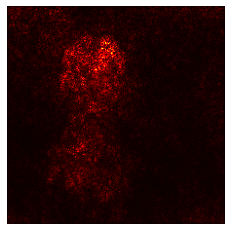

In [23]:
#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
#from torchsummary import summary
from PIL import Image

#Using VGG-16 pretrained model for image classification

model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Opening the image
img = Image.open('./Images/input.jpg') 
plt.imshow(img)
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

### YOUR CODE STARTS HERE ###

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad =True

'''
forward pass through the model to get the logit scores.
'''

logits = model.forward(X)
#logits.requires_grad=True
# Get the index corresponding to the maximum score and the maximum score itself.

logits_max_index = logits.argmax()
logits_max = logits[0,logits_max_index]
print(logits_max)
'''
backward function on logits_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
logits_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
print(X.grad.shape)
saliency_map, _ = torch.max(X.grad.data.abs(),dim=1)
print(saliency_map.shape)
print (torch.mean(saliency_map),torch.max(saliency_map))
# code to plot the saliency map as a heatmap
plt.imshow(saliency_map[0], cmap=plt.cm.hot) #It shows the gradient of the score function wrt image
plt.axis('off')
plt.show()
### YOUR CODE ENDS HERE ###

### Question 7 :Guided Backprop

For a given input image, find out the mean value of the negative saliency map and positive saliency map  of final convolution layer of a pretrained Alexnet using guided backprop for the class prediction corresponding to "highest logit score". 

1.   Mean of Negative Saliency- (0.0156) ; Mean of Positive Saliency-(-0.0153)
2.   Mean of Negative Saliency- (0.0496) ; Mean of Positive Saliency-(-0.0733)
3.   Mean of Negative Saliency- (0.0555) ; Mean of Positive Saliency-(-0.0543)
4.   Mean of Negative Saliency- (0.0765) ; Mean of Positive Saliency-(-0.0234)

In [1]:
import torch
from torch.nn import ReLU
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchvision import models
import cv2
import numpy as np
import torch.nn as nn
from torch.autograd import Variable

In [2]:
def preprocess_image(img, resize_im=True):
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(img) != Image.Image:
        try:
            img = Image.fromarray(img)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        img = img.resize((224, 224), Image.ANTIALIAS)

    im_arr = np.float32(img)
    im_arr = im_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_arr):
        im_arr[channel] /= 255
        im_arr[channel] -= mean[channel]
        im_arr[channel] /= std[channel]
    # Convert to float tensor
    im_float = torch.from_numpy(im_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_float.unsqueeze_(0)
    # Convert to Pytorch variable
    im_var = Variable(im_float, requires_grad=True)
    return im_var



torch.Size([1, 1000])
0.015553286 0.016429065


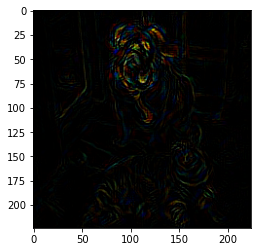

In [16]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        ### YOUR CODE STARTS HERE ###
        # Model in evaluation mode
        model.eval()
        ### YOUR CODE ENDS HERE ###
        self.update_relu()
        self.hold_layers()

    def hold_layers(self):
        def hold_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the initial layer
        initial_layer = list(self.model.features._modules.items())[0][1]
        initial_layer.register_backward_hook(hold_function)

    def update_relu(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
      ### YOUR CODE STARTS HERE ###
        # Pass input through the model
        model_output = self.model(input_image)
        # Zero the model gradients
        self.model.zero_grad()
        # convert label to one hot encoding for targeted backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        print(one_hot_output.shape)
        # Backpropogate using the one hot vector (guided backprop)
        model_output.backward(gradient = one_hot_output)
        # return numpy array after excluding the first channel
        #print(self.gradients.shape)
        gradients_arr = self.gradients.data.numpy()[0]
        return gradients_arr
      ### YOUR CODE ENDS HERE ###


if __name__ == '__main__':
    
    img_path = './Images/cat_dog.png'
    # Read image
    original_image= Image.open(img_path).convert('RGB')
    target_class = 243
    ### YOUR CODE STARTS HERE ###
    # Prepocess the image using the preprocess function defined above
    prep_img = preprocess_image(original_image)
    # Initialize pretrained Alexnet
    model = torchvision.models.alexnet(pretrained=True)
    # Create a class instance of GuidedBackprop
    guidedbackprop = GuidedBackprop(model)
    # Get gradients
    guided_grads = guidedbackprop.generate_gradients(prep_img,target_class)
    # Calculate Positive and negative saliency maps
    neg_sal=(np.maximum(0,-guided_grads)/-guided_grads.min()) # division is done just to normalize the 
    pos_sal=(np.maximum(0,guided_grads)/ guided_grads.max()) # gradient value between 0 to 1
    ### YOUR CODE ENDS HERE ###
    print (np.mean(neg_sal),np.mean(pos_sal))
    neg_sal = neg_sal.transpose(1, 2, 0) # getting channel info to last dim
    neg_sal = (neg_sal*255).astype(np.uint8)
    neg_sal = Image.fromarray(neg_sal)
    plt.imshow(neg_sal)

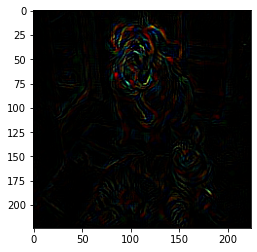

In [17]:
pos_sal = pos_sal.transpose(1, 2, 0) # getting channel info to last dim
pos_sal = (pos_sal*255).astype(np.uint8)
pos_sal = Image.fromarray(pos_sal)
plt.imshow(pos_sal)

In [21]:
a = np.array(pos_sal) - np.array(neg_sal)
print(np.count_nonzero(a))

49412


### Question 8 :Grad-CAM

For a given input image, find out the channel index and the importance(weight) score of most important feauture map (out of all the feature maps of final convolution layer of a pretrained ResNet34 model) using Grad-CAM method for the class prediction corresponding to "highest logit score". Note that Grad-CAM produces final heatmap using the weighted combination of the feature map activations, where weights corresponds to importance score.


1.   Channel index - 608 ; Importance score - 0.0056
2.   Channel index - 379 ; Importance score - 0.0058
3.   Channel index - 113 ; Importance score - 0.004
4.   Channel index - 311 ; Importance score - 0.0069


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import models


def process_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    p_img = img.copy()[:, :, ::-1]
    for i in range(3):
        p_img[:, :, i] = p_img[:, :, i] - means[i]
        p_img[:, :, i] = p_img[:, :, i] / stds[i]
    p_img = np.ascontiguousarray(np.transpose(p_img, (2, 0, 1)))
    p_img = torch.from_numpy(p_img)
    p_img.unsqueeze_(0)
    input = p_img.requires_grad_(True)
    return input

class Feat_Extractor():
    """ register gradients get activations from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class Netout():
    """ Get network output through forward pass and get intermediate layer representation
    and gradient computation for targeted intermediate layer  """

    def __init__(self, net, feat_module, target_layers):
        self.model = net
        self.feature_module = feat_module
        self.feature_extractor = Feat_Extractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
    
            else:
                x = module(x)
        
        return target_activations, x


#visualize heatmap on input image
def visualize(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img = np.uint8(255 * cam)
    plt.imshow(img)


class GradientCam:
    def __init__(self, model, feature_module, target_layer_, cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = Netout(self.model, self.feature_module, target_layer_)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        ''' This function should Return weights corresponding to each feature map of last convolution layer.
        Note that, linear combination of such weights with last conv layer feature map finally 
        produce the explanation map'''

        ### YOUR CODE STARTS HERE ###
        if self.cuda:
            features, output = features.cuda(),output.cuda()
        #else:
            #features, output = fe

        if index == None:
            index = np.argmax(output.data.numpy())

        one_hot = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        
               # obtain gradients of the Netout (self.extractor) 
        #you can use get_gradients() method 
        grads_val = self.extractor.gradients.data.numpy()[0]
        # get the target feature and convert it to numpy.
        target = output.data.numpy()[0]
        #target = 
        #calculate the mean gradient value
        weights = np.mean(grads_val, axis=(1, 2))
         #declare a zero array of size target.shape[1:] to store gradient_value*target value
        class_activation_map = np.ones(target.shape[1:], dtype=np.float32)
        #multiply target[i, :, :] with corresponding gradient weights
        for i, w in enumerate(weights):
            class_activation_map += weights * target[i, :, :]

        class_activation_map = np.maximum(class_activation_map, 0)
        class_activation_map = cv2.resize(class_activation_map, input.shape[2:])
        class_activation_map = class_activation_map - np.min(class_activation_map)
        class_activation_map = class_activation_map / np.max(class_activation_map)
        
        return weights, class_activation_map
        ### YOUR CODE ENDS HERE ###


if __name__ == '__main__':
    
    image = cv2.imread('./Images/cat_dog.png', 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    input = process_image(image)

    net = models.resnet34(pretrained=True)
    grad_cam = GradientCam(model=net, feature_module=net.layer4, \
                       target_layer_=["2"], cuda=True)
    

    target_index = None

    ### call to grad_cam method should return the importance vector corresponds to
    ### each feature map of last convolution layer of pretrained Resnet50

    weights, class_activation_map = grad_cam(input, target_index)

    print ("Most important feature map index: ", np.argmax(weights))
    print ("Its corresponding importance is: ", np.max(weights))

    visualize(image, class_activation_map)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Asus/.cache\torch\checkpoints\resnet34-333f7ec4.pth


UnboundLocalError: local variable 'features' referenced before assignment